# Updated Event Plotting

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import math

In [3]:
original_data_path = "/data/WatChMaL/data/IWCD_mPMT_Short_e-mu-gamma_E0to1000MeV_digihits.h5"
data_file = h5py.File(original_data_path, "r")


hdf5_hit_pmt    = data_file["hit_pmt"]
hdf5_hit_time   = data_file["hit_time"]
hdf5_hit_charge = data_file["hit_charge"]


hit_pmt    = np.memmap(original_data_path, mode="r", shape=hdf5_hit_pmt.shape,
                                    offset=hdf5_hit_pmt.id.get_offset(), dtype=hdf5_hit_pmt.dtype)

hit_time   = np.memmap(original_data_path, mode="r", shape=hdf5_hit_time.shape,
                                    offset=hdf5_hit_time.id.get_offset(), dtype=hdf5_hit_time.dtype)

hit_charge = np.memmap(original_data_path, mode="r", shape=hdf5_hit_charge.shape,
                                    offset=hdf5_hit_charge.id.get_offset(), dtype=hdf5_hit_charge.dtype)

angles     = np.array(data_file['angles'])
energies   = np.array(data_file['energies'])
positions  = np.array(data_file['positions'])
labels     = np.array(data_file['labels'])
root_files = np.array(data_file['root_files'])

In [4]:
barrel_map_array_idxs = [6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 15, 16, 17, 12, 13, 14, 18]
pmts_per_mpmt = 19

event_hits_index = np.append(data_file["event_hits_index"], hdf5_hit_pmt.shape[0]).astype(np.int64)

mpmt_positions_file = '/data/WatChMaL/data/IWCDshort_mPMT_image_positions.npz'
mpmt_positions   = np.load(mpmt_positions_file)['mpmt_image_positions']

data_size = np.max(mpmt_positions, axis=0) + 1
n_channels = pmts_per_mpmt
data_size = np.insert(data_size, 0, n_channels)

# Load Geometry Files

In [5]:
full_tank_geo_file_path = '/fast_scratch/WatChMaL/data/mPMT_full_geo.npz'
full_tank_geofile = np.load(full_tank_geo_file_path, allow_pickle=True)

In [6]:
geo_path = '/fast_scratch/WatChMaL/data/geo_mPMTshort.npz'
geofile = np.load(geo_path, allow_pickle=True)

# Load Full Tank Data and Find Parameters

In [106]:
full_tank_tubes = full_tank_geofile[ 'tube_no' ]

full_tank_tube_xyz = full_tank_geofile[ 'position' ]
full_tank_tube_x   = full_tank_tube_xyz[:,0]
full_tank_tube_y   = full_tank_tube_xyz[:,1]
full_tank_tube_z   = full_tank_tube_xyz[:,2]
R =  (full_tank_tube_x.max() - full_tank_tube_x.min())/2.0

full_tank_tube_dir = full_tank_geofile[ 'orientation']

In [107]:
def PMT_to_flat_cylinder_map_positive( tubes, tube_xyz ):
    """
    Build dictionary of PMT number, to (x,y) on a flat cylinder
    
    N.B. Tube numbers in full geometry file go from 1:NPMTs, but it seems like
    the event data number from 0:NPMTs-1, so subtracting 1 from tube number here?
    
    """
    mapping = {}
    for idx, tube in enumerate(tubes):
        x = tube_xyz[idx,0]
        y = tube_xyz[idx,1]
        z = tube_xyz[idx,2]
        if ( y > 500. ):
            # in top circle of cylinder
            xflat = x+1162.7
            yflat = 2165.2 + z
            mapping[ int( tube-1 ) ] = [ int(round(xflat)), int(round(yflat)) ]
            
        elif ( y < -500.):
            # in bottom circle of cylinder
            xflat = x+1162.7
            yflat = 370.1 + z
            mapping[ int( tube-1 ) ] = [ int(round(xflat)), int(round(yflat)) ]
            
        else:
            # in barrel part of cylinder
            theta = math.atan2( z, x )
            xflat = R * theta + 1162.7
            yflat = y + 1267.7
            mapping[ int( tube-1 ) ] = [ int(round(xflat)), int(round(yflat)) ]
    return mapping

PMTFlatMapPositive = PMT_to_flat_cylinder_map_positive( full_tank_tubes, full_tank_tube_xyz )

In [160]:
print("Full tank dimensions: ")
print(full_tank_tube_x.max())
print(full_tank_tube_y.max())
print(full_tank_tube_z.max())

Full tank dimensions: 
370.0958251953125
517.4490356445312
370.0958251953125


In [161]:
a = list(PMTFlatMapPositive.values())
a_x = np.array([elem[0] for elem in a])
a_y = np.array([elem[1] for elem in a])

print("Full tank PMT max and min: ")

print(a_x.min())
print(a_x.max())

print(a_y.min())
print(a_y.max())

Full tank PMT max and min: 
17
2496
101
2099


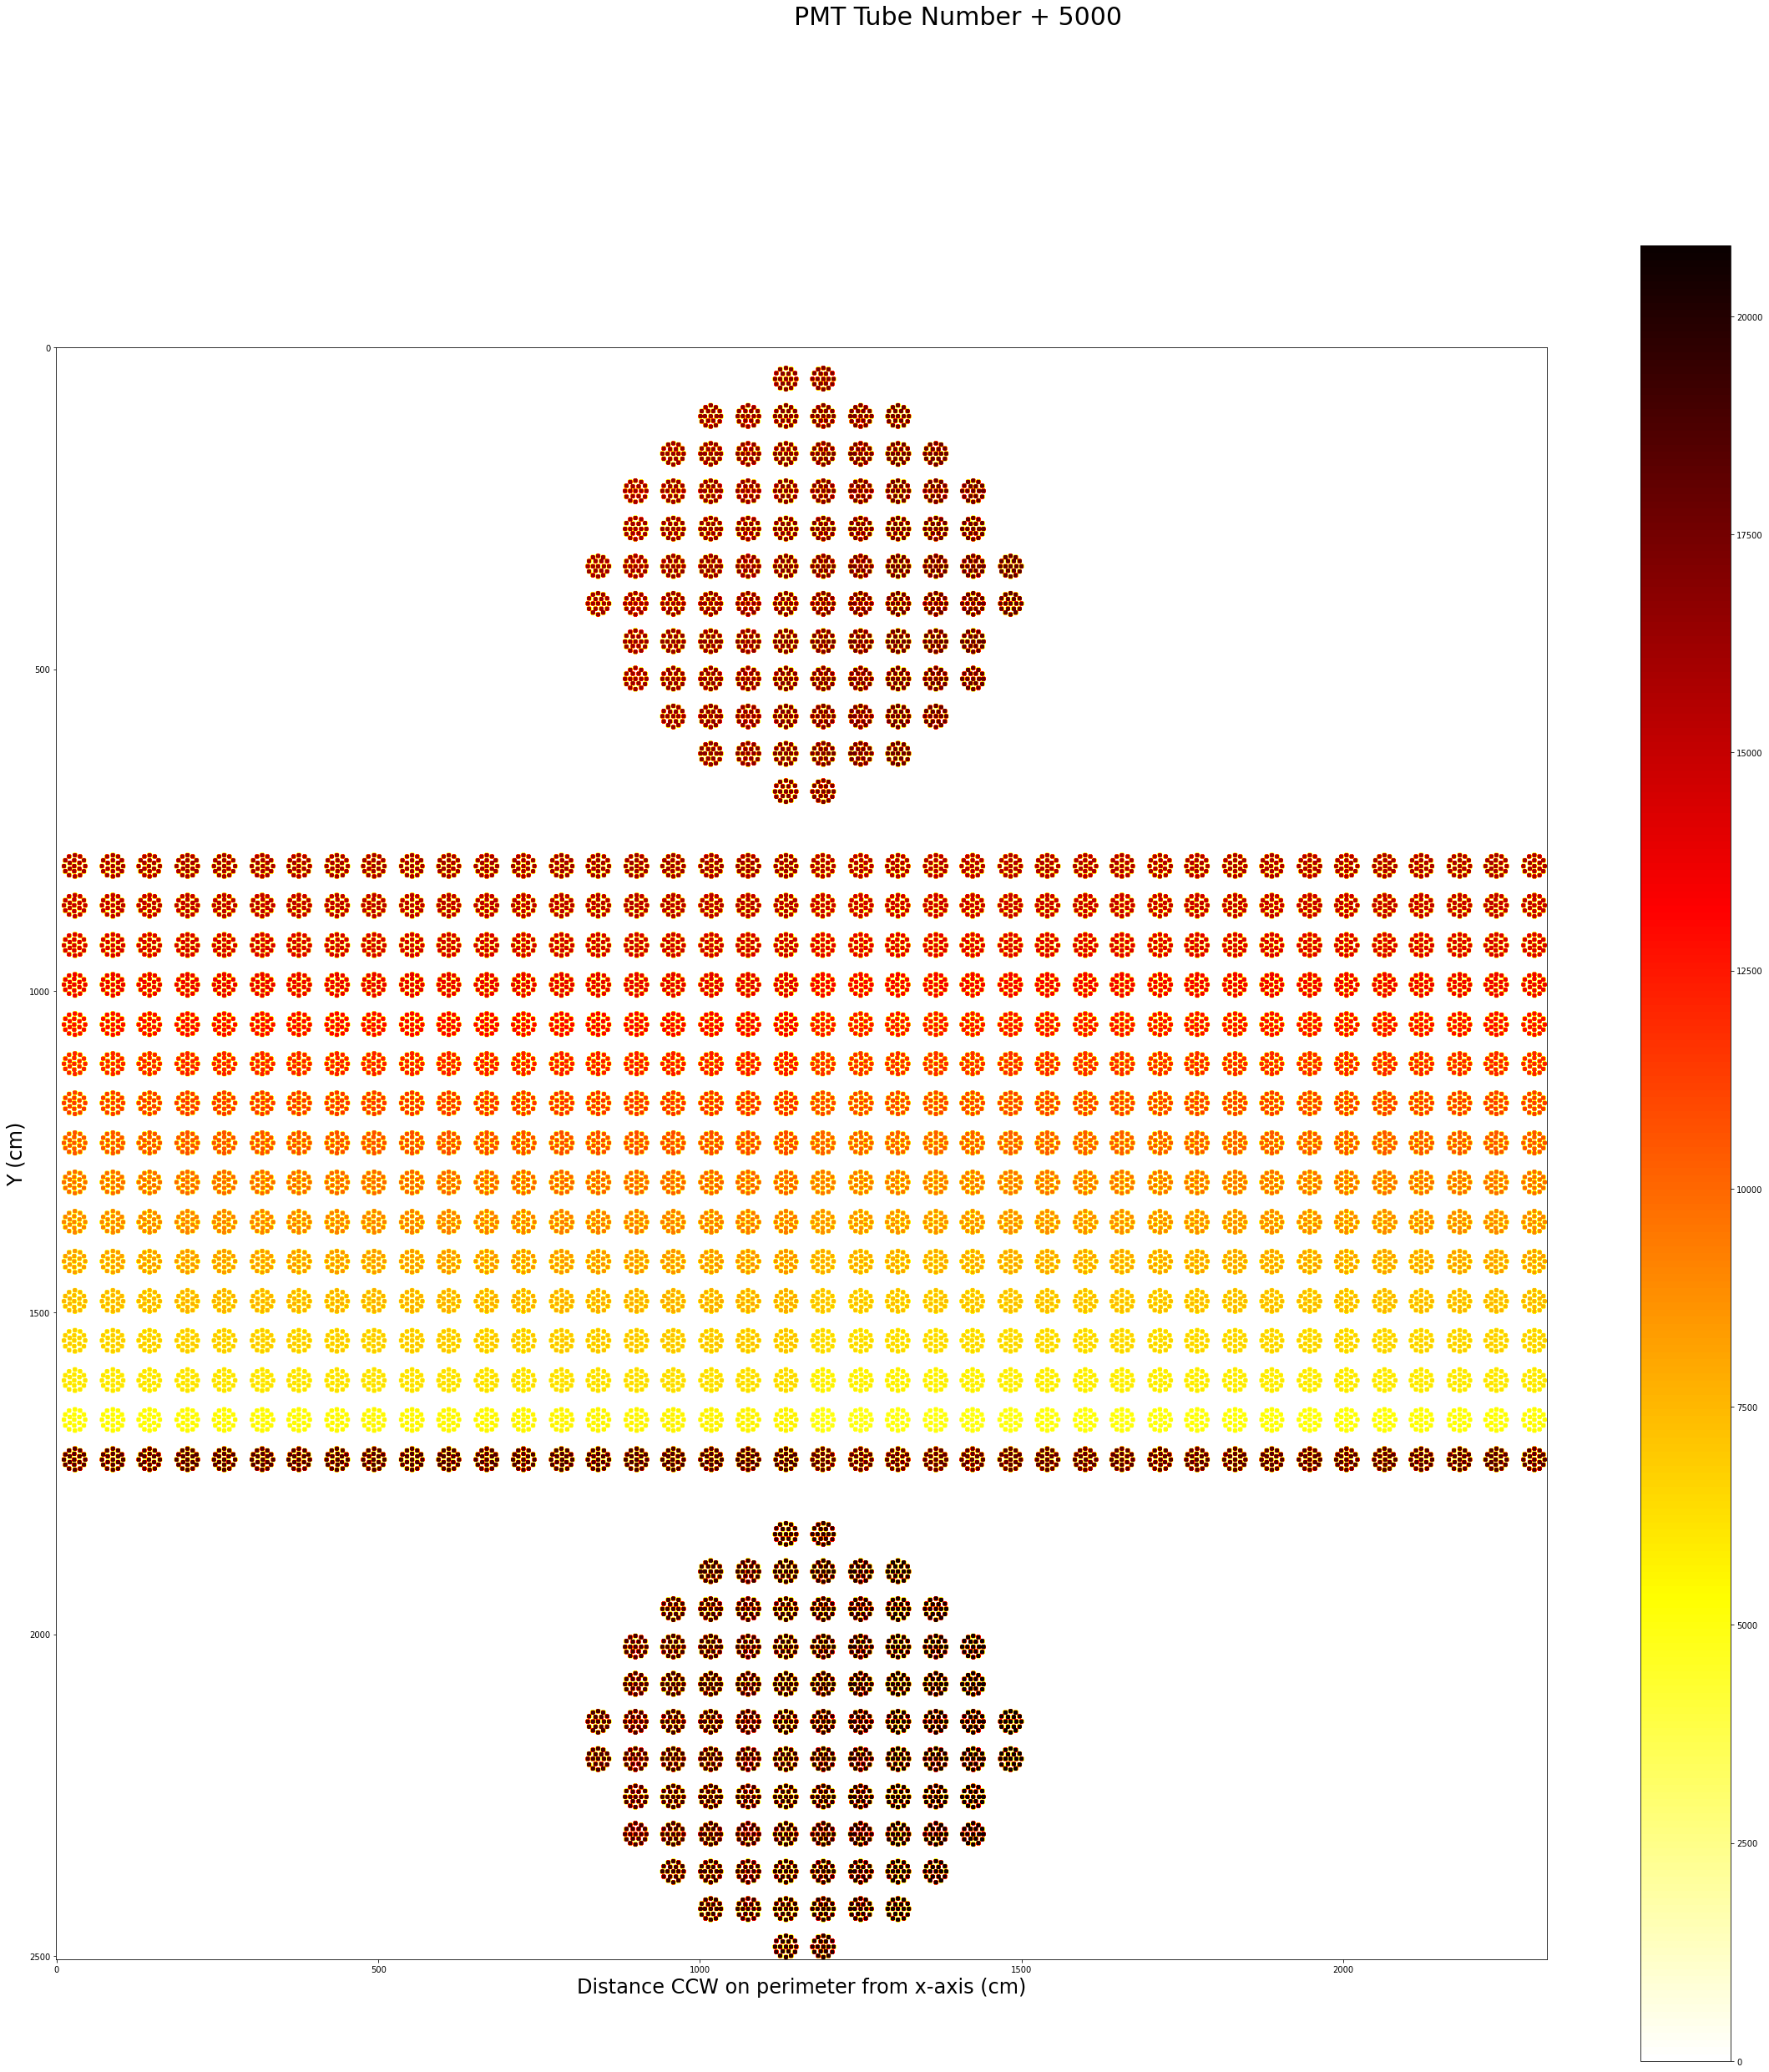

In [110]:
fig = plt.figure(figsize=[40,40]) 

preimage = np.zeros( [2506, 2317] )
for tube in PMTFlatMapPositive:
    for dx in range(-3,4):
        for dy in range(-3,4):
            if abs(dx)==3 and abs(dy)==3:
                continue
            preimage[ PMTFlatMapPositive[tube][1]+dx, PMTFlatMapPositive[tube][0]+dy ] = tube + 5000
plt.imshow( preimage )
fig.suptitle('PMT Tube Number + 5000',fontsize=30)
plt.xlabel('Distance CCW on perimeter from x-axis (cm)', fontsize=24)
plt.ylabel('Y (cm)', fontsize=24)
#plt.set_cmap('Greys')
plt.set_cmap('hot_r')
#plt.set_cmap('gist_heat_r')
plt.colorbar()
#plt.savefig( 'mpmt_flatmap_positions_img.pdf',dpi=300)


# Load Short Tank Data and Find Parameters

In [154]:
tubes = geofile[ 'tube_no' ]

tube_xyz = geofile[ 'position' ]
tube_x   = tube_xyz[:,0]
tube_y   = tube_xyz[:,1]
tube_z   = tube_xyz[:,2]

R =  (tube_x.max() - tube_x.min())/2.0

tube_dir = geofile[ 'orientation']

In [162]:
print("Short tank dimensions: ")
print(tube_x.max())
print(tube_y.max())
print(tube_z.max())

Short tank dimensions: 
399.0980529785156
296.4490661621094
399.0980529785156


# Display 3D Plots

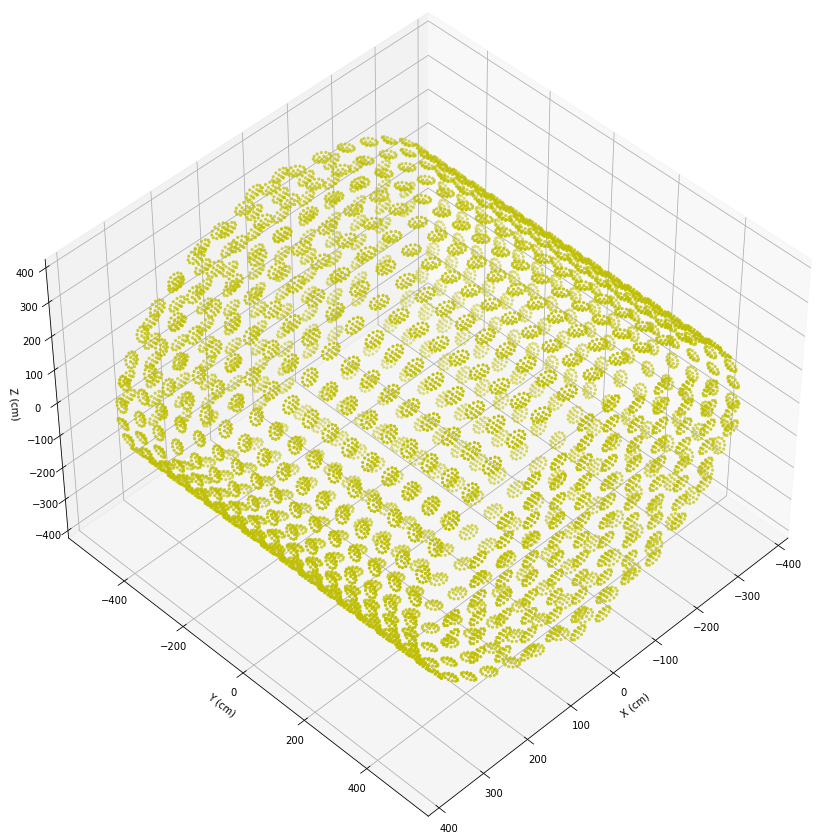

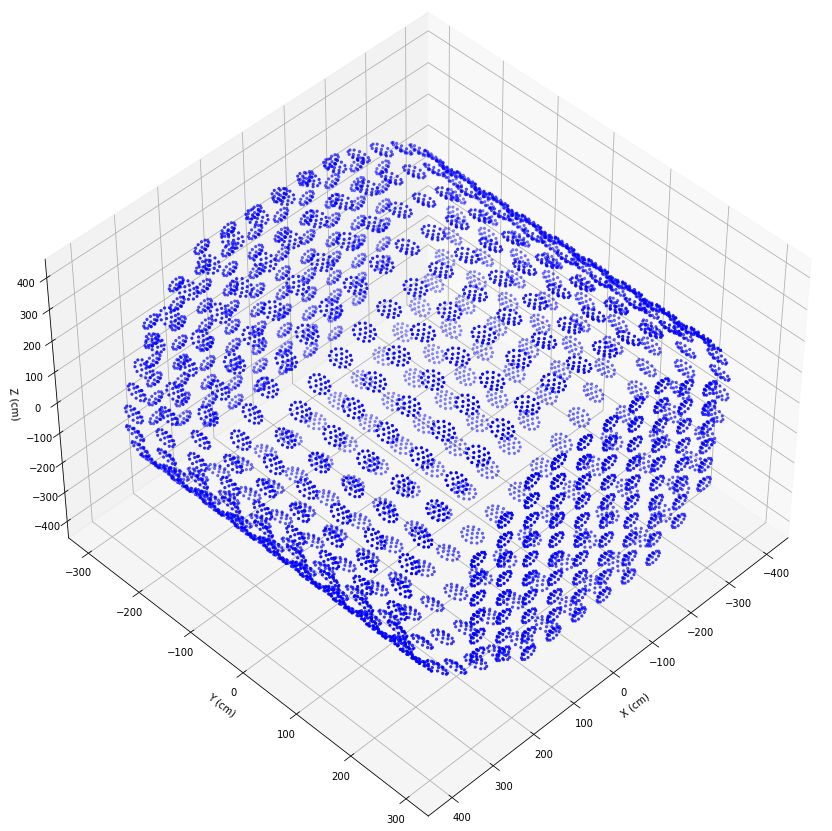

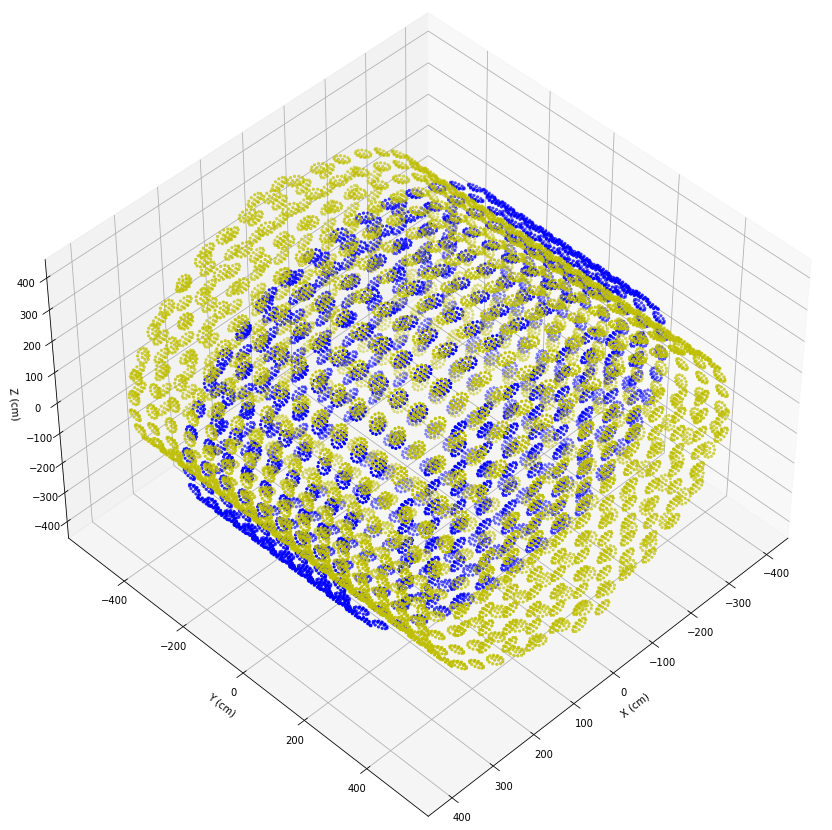

In [10]:
fig = plt.figure(figsize=[15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter( full_tank_tube_x, full_tank_tube_y, full_tank_tube_z, marker='.', c='y', label='full'  )
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
ax.view_init(elev=45.0, azim=45.0)
plt.show()

fig = plt.figure(figsize=[15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter( tube_x, tube_y, tube_z, marker='.', c='b', label='short'  )
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
ax.view_init(elev=45.0, azim=45.0)
plt.show()


fig = plt.figure(figsize=[15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter( tube_x, tube_y, tube_z, marker='.', c='b', label='short'  )
ax.scatter( full_tank_tube_x, full_tank_tube_y, full_tank_tube_z, marker='.', c='y', label='full'  )
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
ax.view_init(elev=45.0, azim=45.0)
plt.show()

# Define Parameters For Functions

In [ ]:
"""
### Comparison with old endcaps file values ### 

y_offset = (barrel_height + barrel_radius + 10) = 897.6

positive
x_offset = pi*barrel_radius = 1162.7
bottom_offset = (barrel_height + barrel_radius + 10) + barrel_radius = 897.6 + barrel_radius = 1267.7
upper_endcap_offset = bottom_offset + y_offset = 1267.7 + 897.6 = 2165.2

preimage = np.zeros( [2506, 2317] )

"""

In [166]:
barrel_half_height = 296.4490661621094
barrel_radius = 399.0980529785156

endcap_limit = 290.

# offset for endcaps due to flattening
y_offset = barrel_half_height + barrel_radius

# offsets when making plot assume positive values only
positive_x_offset = np.pi*barrel_radius
lower_endcap_offset = y_offset + barrel_radius
upper_endcap_offset = y_offset + lower_endcap_offset

# set up dimensions for preimage with short tank data
min_pmt_x_value = 17
max_pmt_x_value = 2496

min_pmt_y_value = 101
max_pmt_y_value = 2099


preimage_dimensions = [max_pmt_y_value + min_pmt_y_value + 1, max_pmt_x_value + min_pmt_x_value + 1]

# Set Up Functions

In [204]:
def get_event_data_from_index(item):
    start = event_hits_index[item]
    stop  = event_hits_index[item + 1]

    hit_pmts    = hit_pmt[start:stop].astype(np.int16)
    hit_charges = hit_charge[start:stop]
    hit_times   = hit_time[start:stop]

    hit_mpmts = hit_pmts // pmts_per_mpmt
    hit_pmt_in_modules = hit_pmts % pmts_per_mpmt

    hit_rows = mpmt_positions[hit_mpmts, 0]
    hit_cols = mpmt_positions[hit_mpmts, 1]

    sample_data = np.zeros(data_size)
    sample_data[hit_pmt_in_modules, hit_rows, hit_cols] = hit_charges

    # fix barrel array indexing to match endcaps in xyz ordering
    barrel_map_array_idxs = [6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 15, 16, 17, 12, 13, 14, 18]
    sample_data[:, 12:28, :] = sample_data[barrel_map_array_idxs, 12:28, :]
    moved_data = np.moveaxis(sample_data, 0, -1)
    print(sample_data.shape)
    print(hit_pmts.shape)
    print(hit_charges.shape)
    
    return hit_pmts, hit_charges #moved_data

In [153]:
def PMT_to_flat_cylinder_mapping( tubes, tube_xyz ):
    """
    Build dictionary of PMT number, to (x,y) on a flat cylinder
    
    N.B. Tube numbers in full geometry file go from 1:NPMTs, but it seems like
    the event data number from 0:NPMTs-1, so subtracting 1 from tube number here?
    """
    mapping = {}
    for idx, tube in enumerate(tubes):
        x = tube_xyz[idx,0]
        y = tube_xyz[idx,1]
        z = tube_xyz[idx,2]
        if ( y > endcap_limit ):
            # in top circle of cylinder
            xflat = x
            yflat = y_offset + z
            mapping[ int( tube-1 ) ] = [ xflat, yflat ]
            
        elif ( y < -endcap_limit):
            # in bottom circle of cylinder+
            xflat = x
            yflat = -y_offset + z
            mapping[ int( tube-1 ) ] = [ xflat, yflat ]
            
        else:
            # in barrel part of cylinder
            theta = math.atan2( z, x )
            xflat = R * theta
            yflat = y
            mapping[ int( tube-1 ) ] = [ xflat, yflat ]
    return mapping

PMTFlatMapping = PMT_to_flat_cylinder_mapping( tubes, tube_xyz )


In [156]:
def PMT_to_flat_cylinder_map_positive( tubes, tube_xyz ):
    """
    Build dictionary of PMT number, to (x,y) on a flat cylinder
    
    N.B. Tube numbers in full geometry file go from 1:NPMTs, but it seems like
    the event data number from 0:NPMTs-1, so subtracting 1 from tube number here?
    
    """
    mapping = {}
    for idx, tube in enumerate(tubes):
        x = tube_xyz[idx,0]
        y = tube_xyz[idx,1]
        z = tube_xyz[idx,2]
        if ( y > endcap_limit ):
            # in top circle of cylinder
            xflat = x + positive_x_offset
            yflat = z + upper_endcap_offset
            mapping[ int( tube-1 ) ] = [ int(round(xflat)), int(round(yflat)) ]
            
        elif ( y < -endcap_limit):
            # in bottom circle of cylinder
            xflat = x + positive_x_offset
            yflat = z + barrel_radius
            mapping[ int( tube-1 ) ] = [ int(round(xflat)), int(round(yflat)) ]
            
        else:
            # in barrel part of cylinder
            theta = math.atan2( z, x )
            xflat = R * theta + np.pi*barrel_radius
            yflat = y + lower_endcap_offset
            mapping[ int( tube-1 ) ] = [ int(round(xflat)), int(round(yflat)) ]
    return mapping

PMTFlatMapPositive = PMT_to_flat_cylinder_map_positive( tubes, tube_xyz )

In [163]:
a = list(PMTFlatMapPositive.values())
a_x = np.array([elem[0] for elem in a])
a_y = np.array([elem[1] for elem in a])

print("Full tank PMT max and min: ")

print(a_x.min())
print(a_x.max())

print(a_y.min())
print(a_y.max())

Full tank PMT max and min: 
17
2496
101
2099


In [167]:
def EventDisplay( tubes, quantities, title="Charge", cutrange=[-1,-1] ):
    """
    tubes == np.array of PMTs that were hit
    quantities == np.array of PMT quantities (either charge or time)
    title == title to add to display
    cutrange == minimum and maximum values on plot (or set both same for default)
    """
    
    fig = plt.figure(figsize=[40,40])
    preimage = np.zeros( preimage_dimensions )
    #maxquantity = quantities.max()
    #preimage *= maxquantity*1.2
    imgmin = quantities.min()
    imgmax = quantities.max()
    for idx, tube in enumerate( tubes ):
        if cutrange[0] != cutrange[1]:
            if quantities[idx] < cutrange[0] or quantities[idx] > cutrange[1]:
                continue
        for dx in range(-3,4):
            for dy in range(-3,4):
                if abs(dx)==3 and abs(dy)==3:
                    continue
                    
                #print( "idx=", idx, " len(quantities)=",len(quantities), " tube=", tube, " len(PMTFlatMap)=", len(PMTFlatMapPositive))
                preimage[ PMTFlatMapPositive[tube][1]+dx, PMTFlatMapPositive[tube][0]+dy ] = quantities[idx]

    if cutrange[0] != cutrange[1]:
        imgmin = cutrange[0]
        imgmax = cutrange[1]
    
    plt.imshow( preimage, extent = [-x_offset,x_offset,-lower_endcap_offset,lower_endcap_offset], vmin=imgmin, vmax=imgmax )
    fig.suptitle(title, fontsize=20)
    plt.xlabel('Distance CCW on perimeter from x-axis (cm)', fontsize=18)
    plt.ylabel('Y (cm)', fontsize=16)
    
    #plt.set_cmap('YlGnBu')
    #plt.set_cmap('cubehelix_r')
    #plt.set_cmap('gnuplot2_r')
    
    plt.set_cmap('gist_heat_r')
    plt.colorbar()


# Test Short Tank Plotting

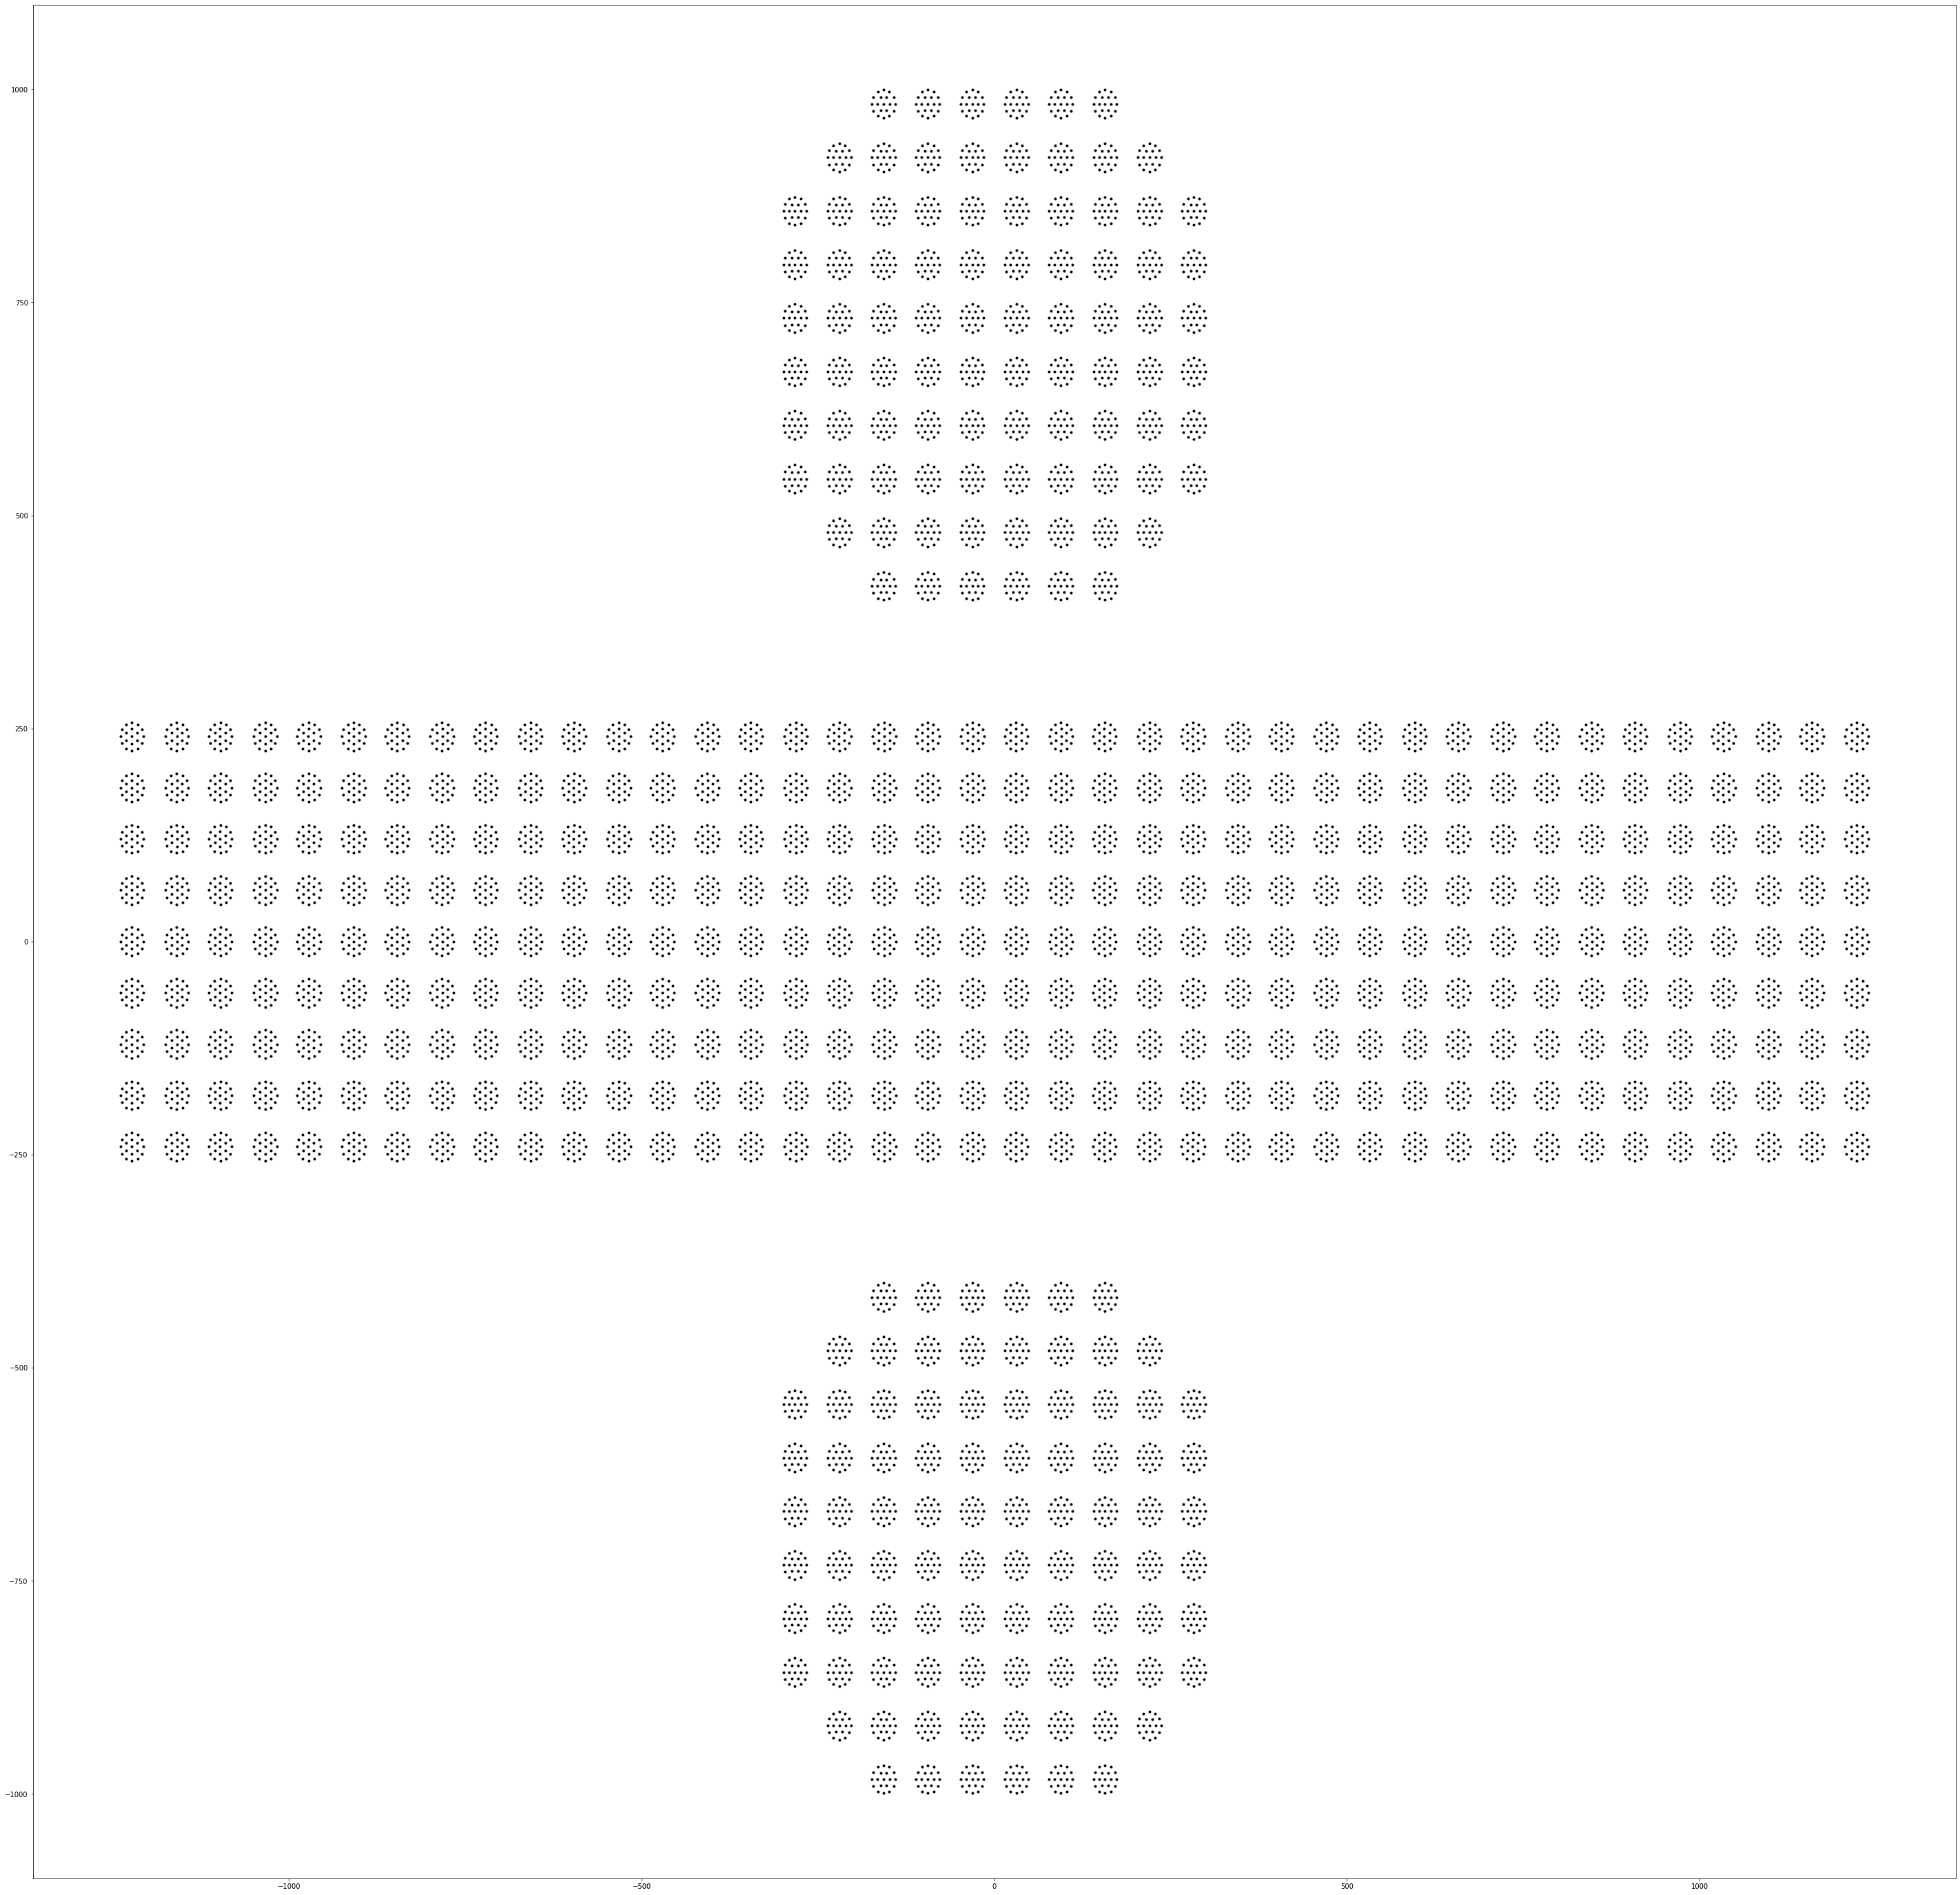

In [145]:
xflatvals = []
yflatvals = []
for tube in PMTFlatMapping:
    xflatvals.append( PMTFlatMapping[tube][0] )
    yflatvals.append( PMTFlatMapping[tube][1] )

fig = plt.figure(figsize=[50,50])    
plt.plot( xflatvals, yflatvals, '.', color='black' )

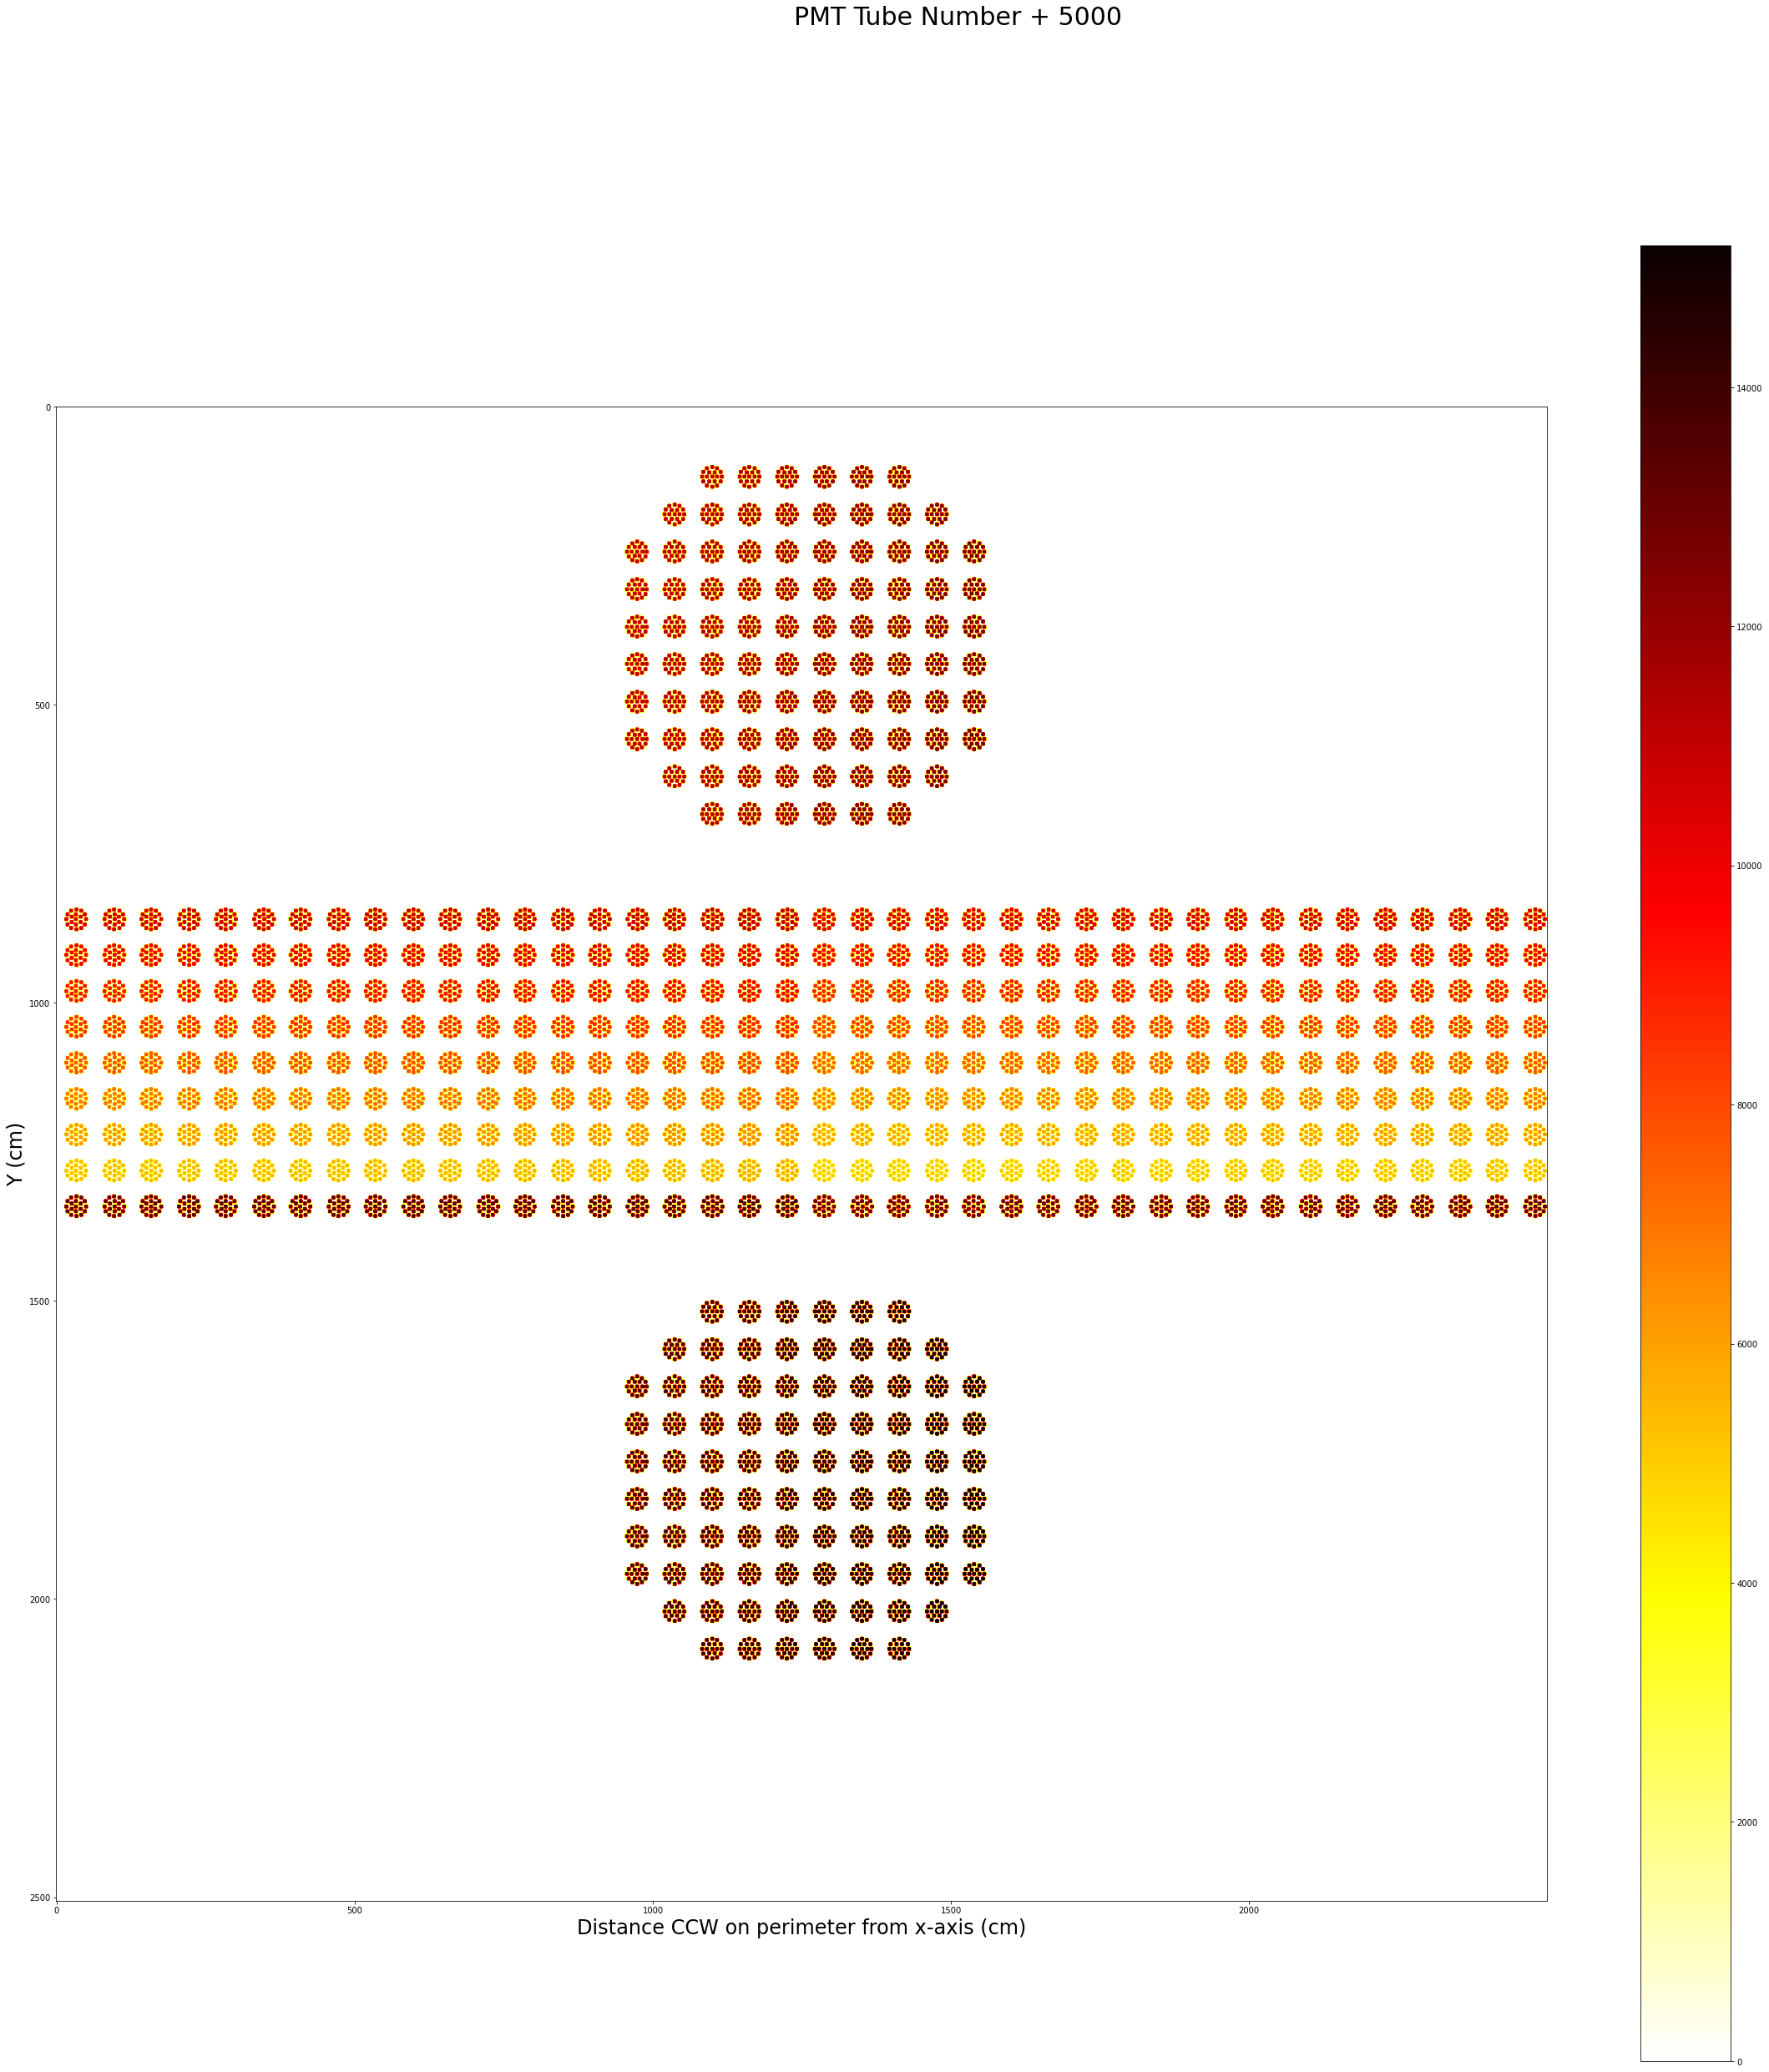

In [139]:
fig = plt.figure(figsize=[40,40]) 

#preimage = np.zeros( [2506, 2317] )
#preimage = np.zeros( [3000, 3000] )
preimage = np.zeros( [2506, 2496 + 3 + 1] )
for tube in PMTFlatMapPositive:
    for dx in range(-3,4):
        for dy in range(-3,4):
            if abs(dx)==3 and abs(dy)==3:
                continue
            preimage[ PMTFlatMapPositive[tube][1]+dx, PMTFlatMapPositive[tube][0]+dy ] = tube + 5000
plt.imshow( preimage )
fig.suptitle('PMT Tube Number + 5000',fontsize=30)
plt.xlabel('Distance CCW on perimeter from x-axis (cm)', fontsize=24)
plt.ylabel('Y (cm)', fontsize=24)
#plt.set_cmap('Greys')
plt.set_cmap('hot_r')
#plt.set_cmap('gist_heat_r')
plt.colorbar()
#plt.savefig( 'mpmt_flatmap_positions_img.pdf',dpi=300)

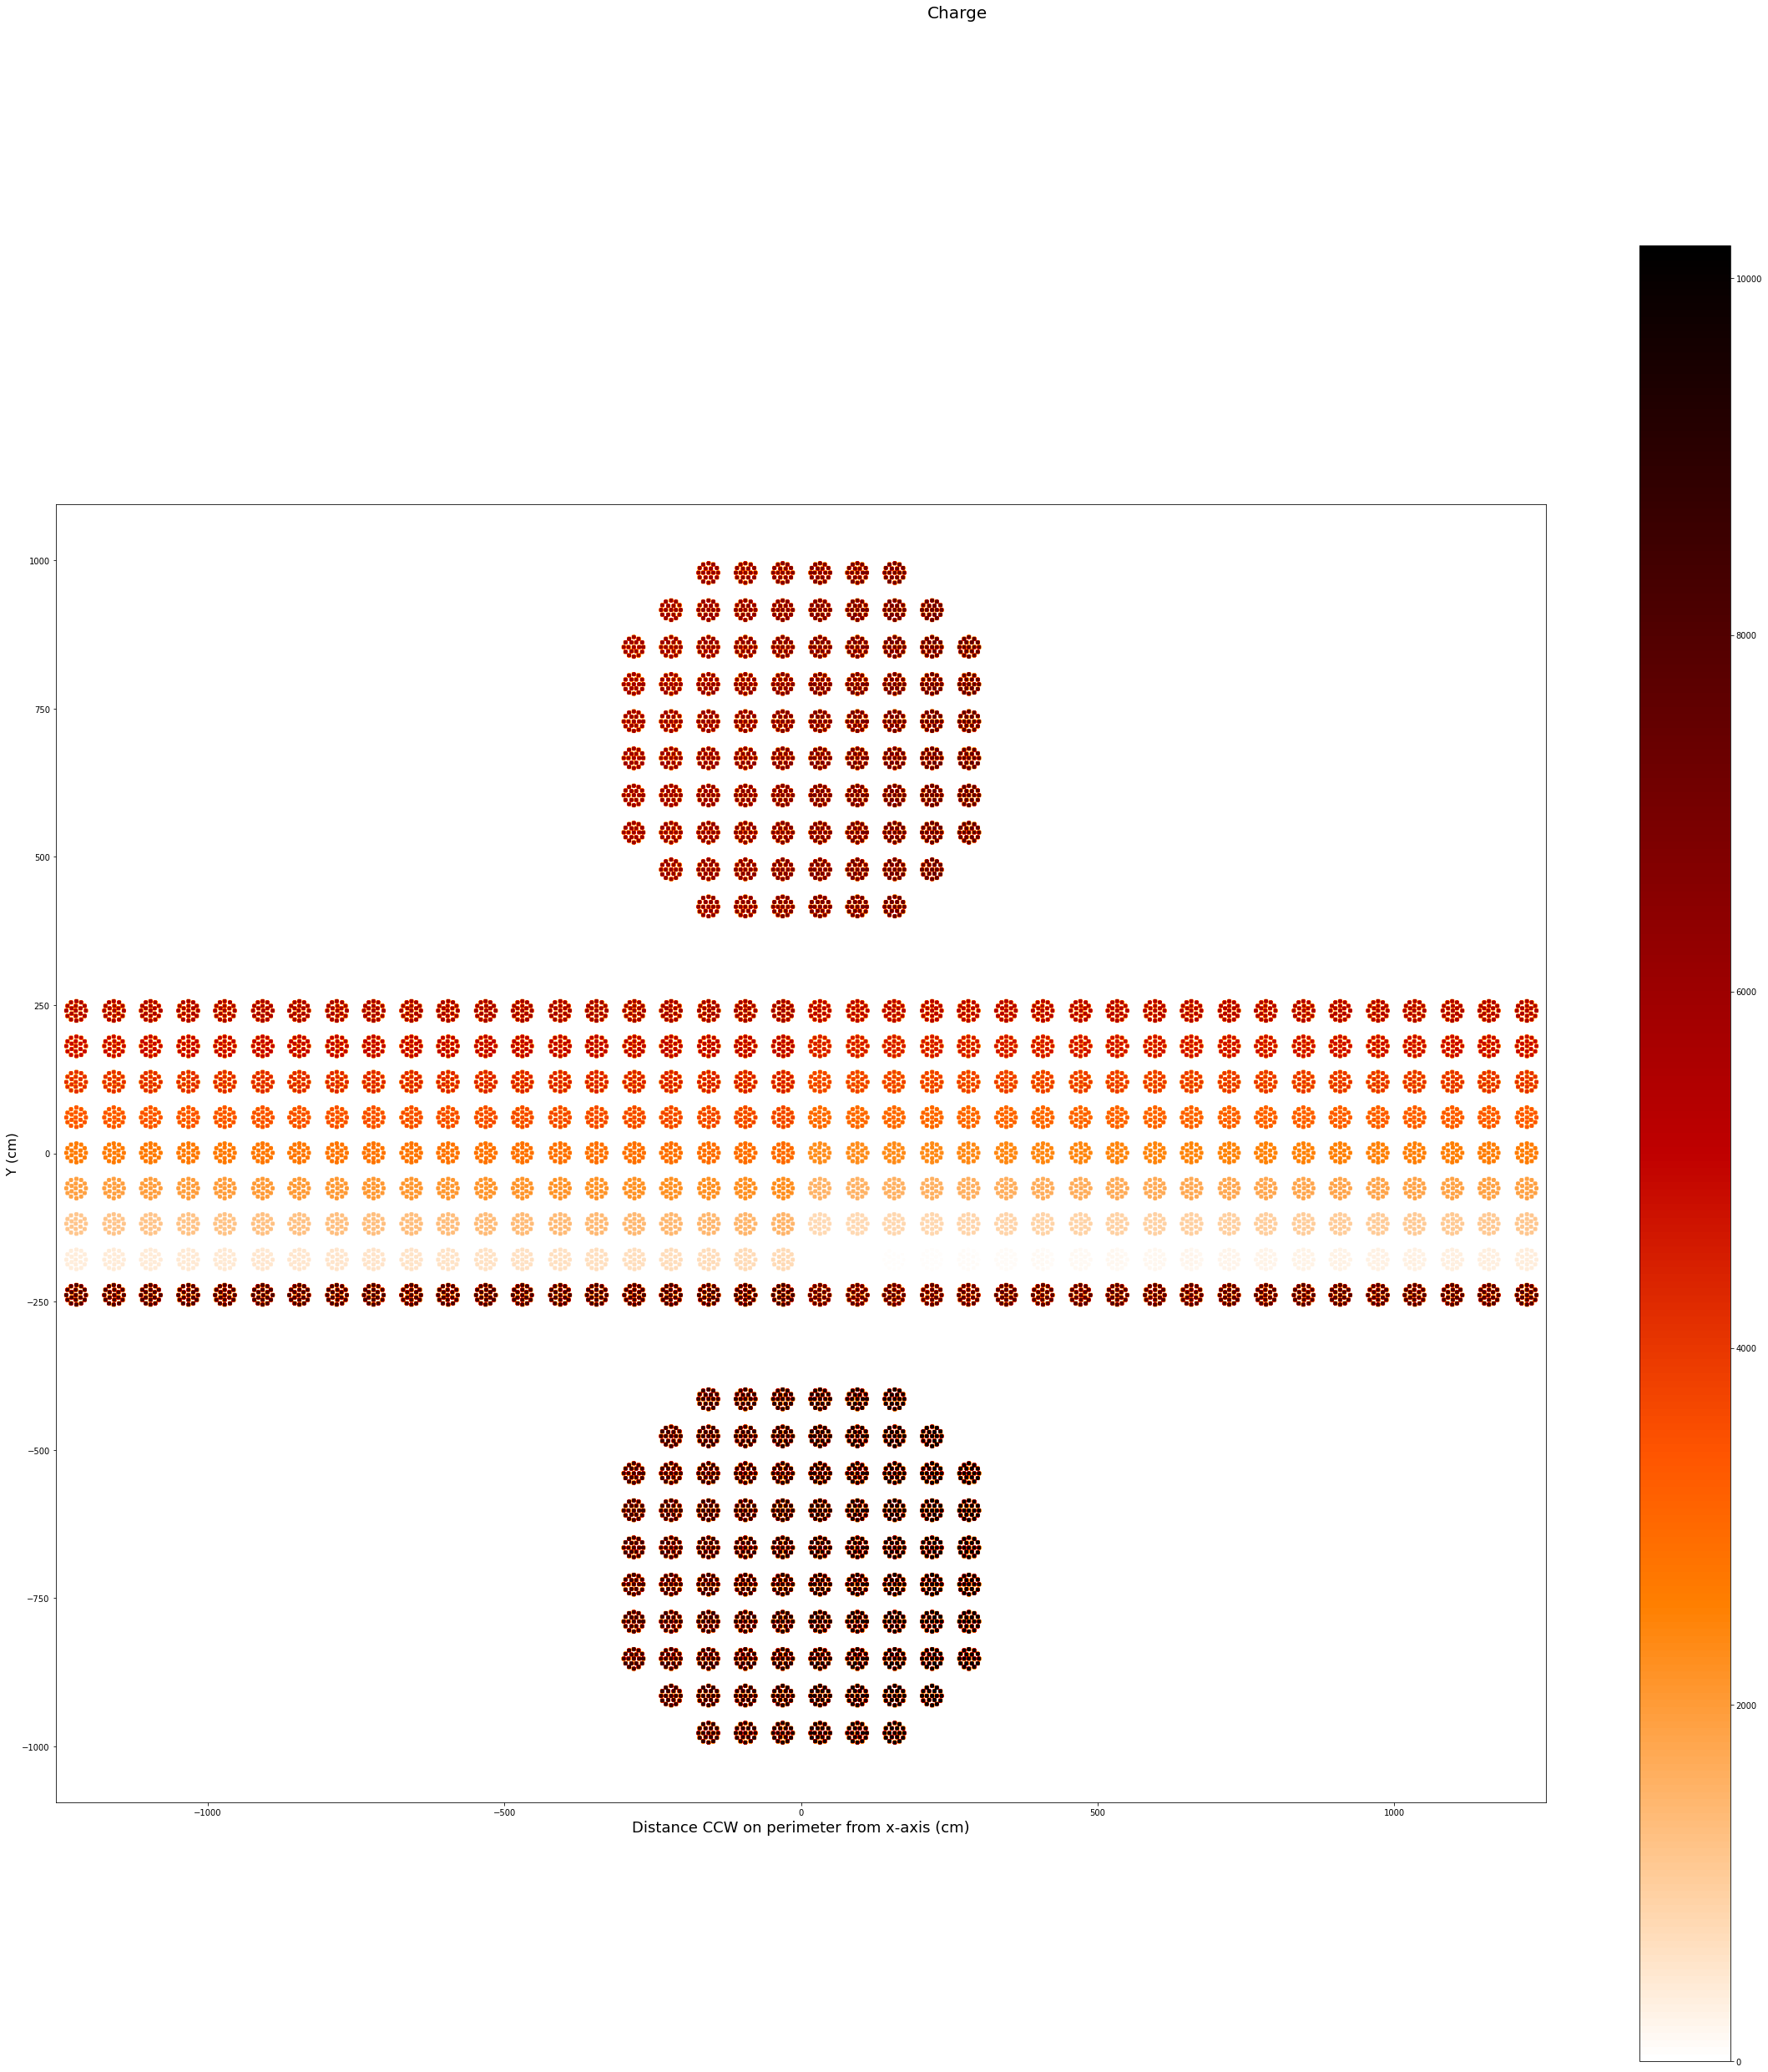

In [168]:
EventDisplay(tubes - 1, tubes - 1)

# Event Plotting

In [205]:
test_event_pmts, test_event_charges = get_event_data_from_index(0)

(19, 29, 40)
(2068,)
(2068,)


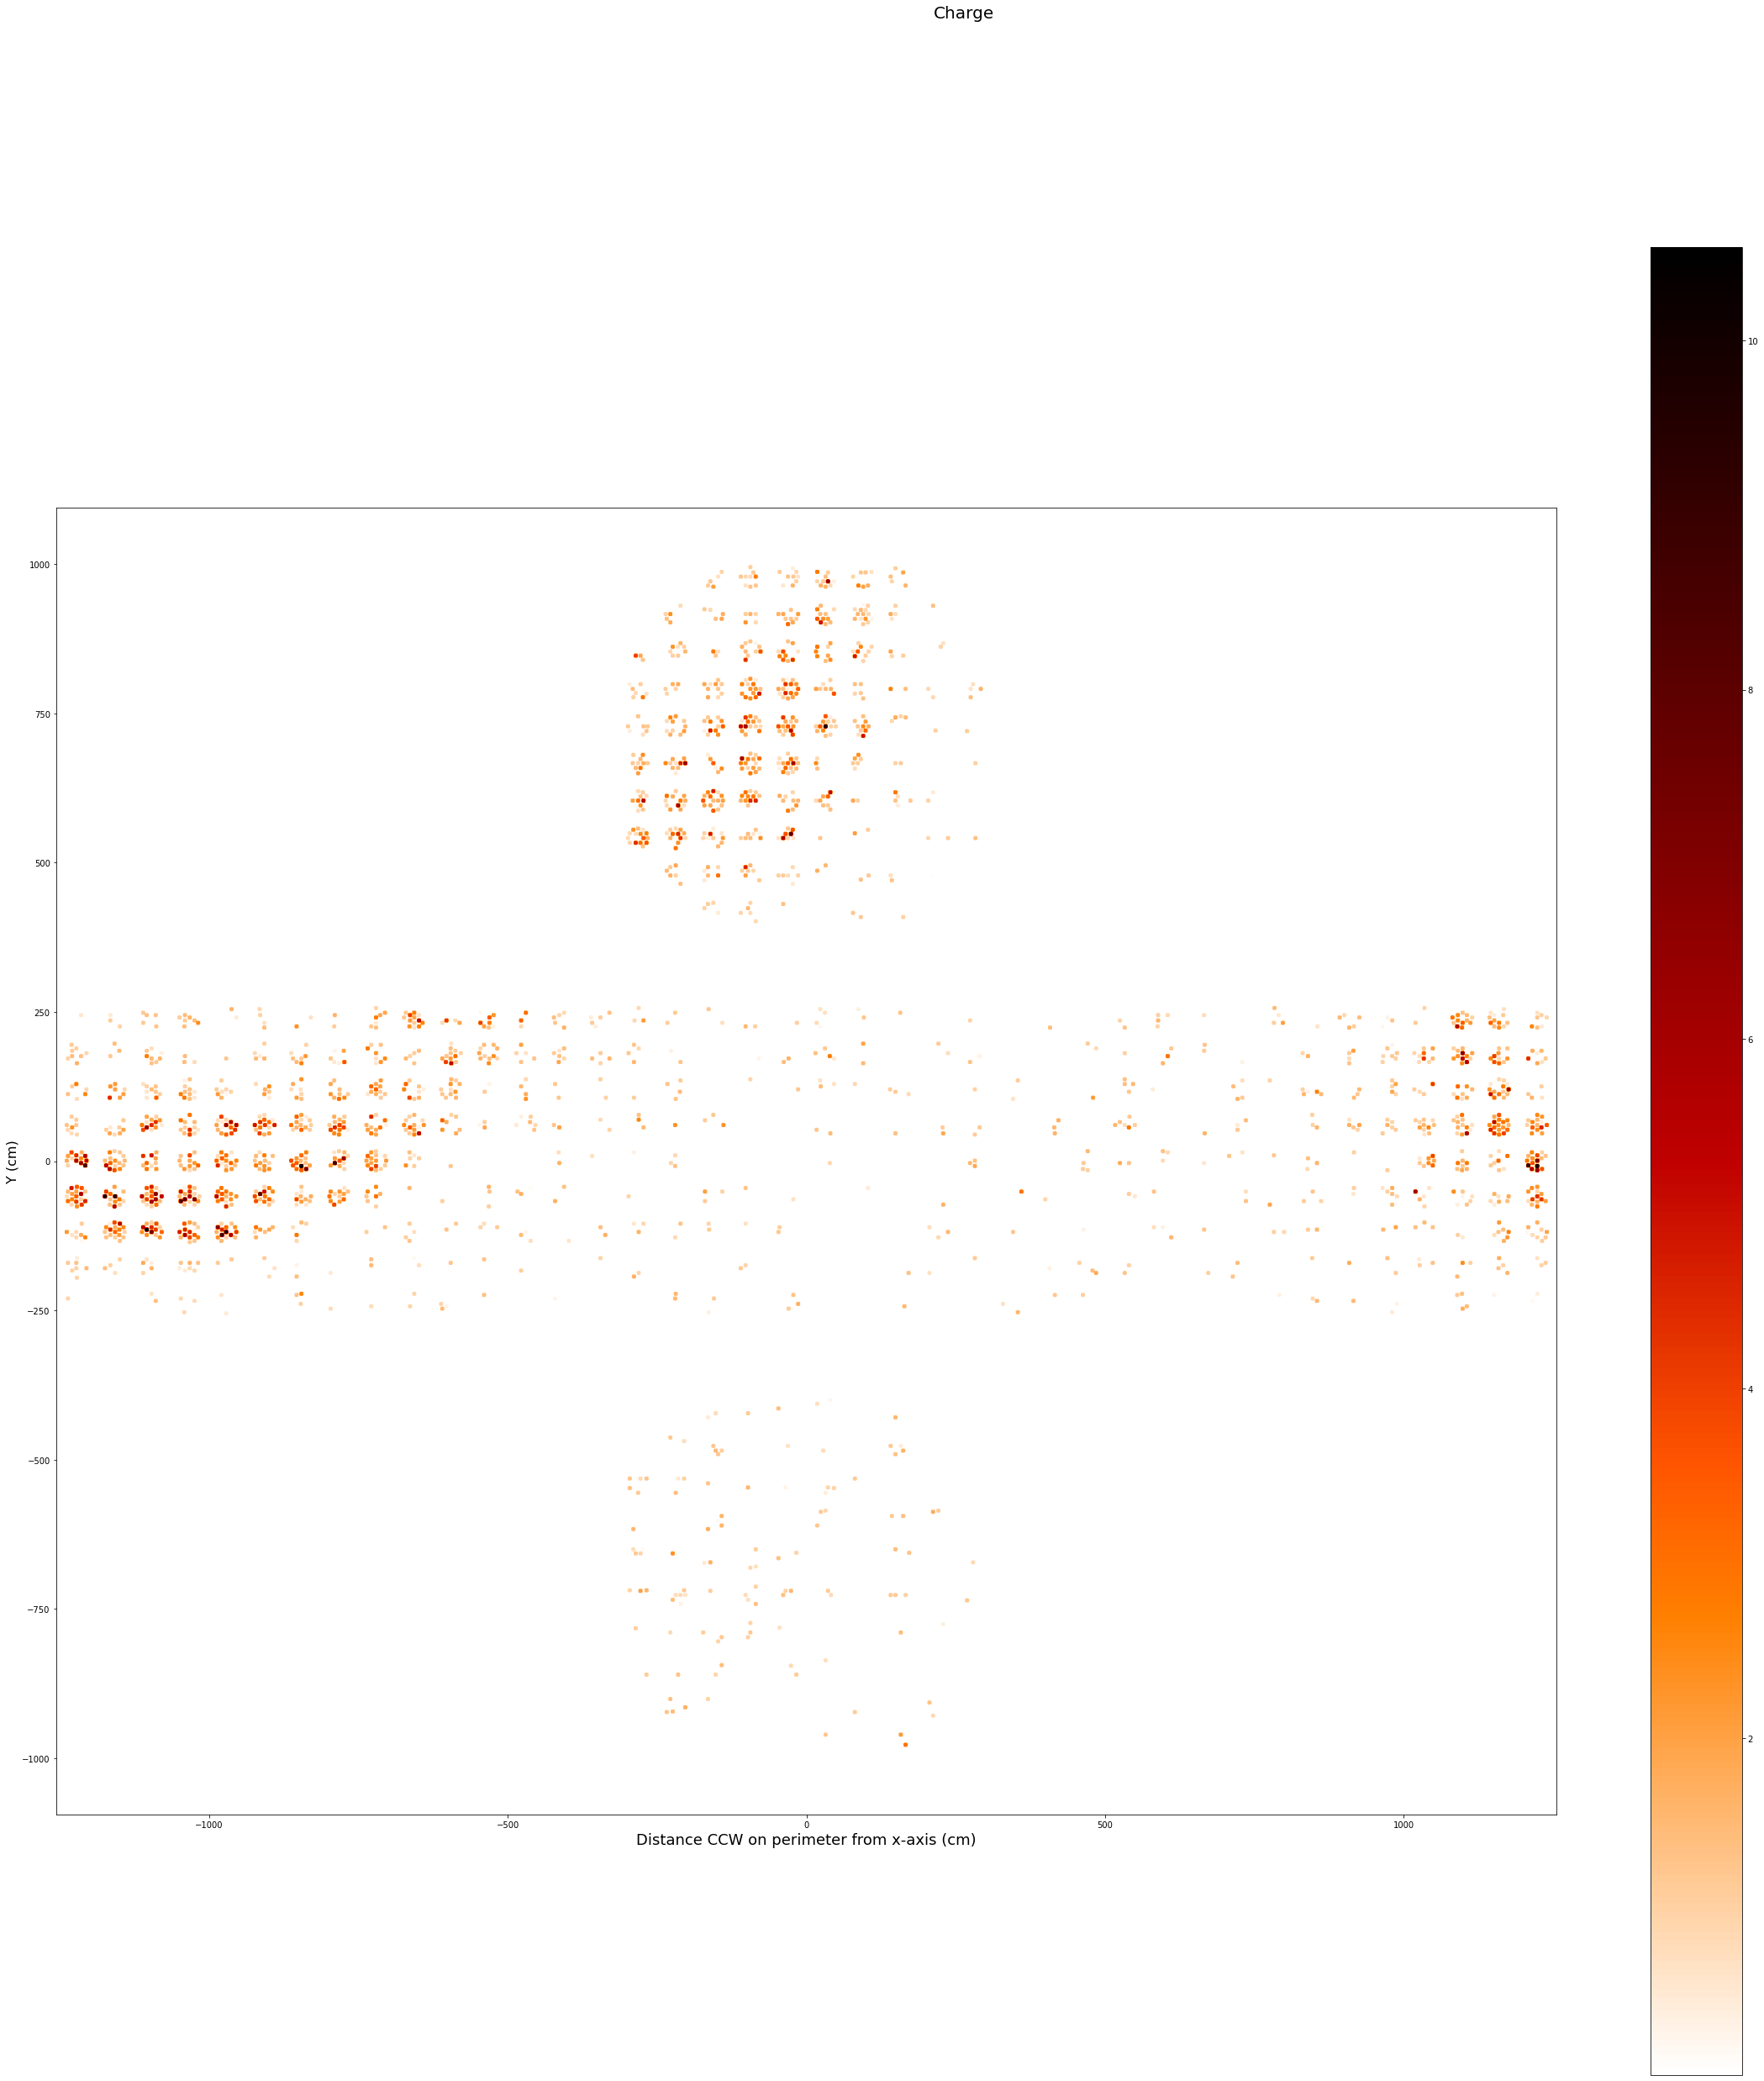

In [174]:
EventDisplay(test_event_pmts, test_event_charges)

# Experimental Plotting

In [213]:
def PMT_to_upper_endcap_mapping( tubes, tube_xyz ):
    """
    """
    subset_tubes = []
    for idx, tube in enumerate(tubes):
        x = tube_xyz[idx,0]
        y = tube_xyz[idx,1]
        z = tube_xyz[idx,2]
        if ( y > endcap_limit ):
            # in top circle of cylinder
            subset_tubes.append(tube)
    return subset_tubes

upper_endcap_subset_tubes = PMT_to_upper_endcap_mapping( tubes, tube_xyz )

In [214]:
def PMT_to_lower_endcap_mapping( tubes, tube_xyz ):
    """
    """
    subset_tubes = []
    for idx, tube in enumerate(tubes):
        x = tube_xyz[idx,0]
        y = tube_xyz[idx,1]
        z = tube_xyz[idx,2]
        if ( y < -endcap_limit ):
            # in top circle of cylinder
            subset_tubes.append(tube)
    return subset_tubes #mapping

lower_endcap_subset_tubes = PMT_to_lower_endcap_mapping( tubes, tube_xyz )

In [215]:
def PMT_to_barrel_mapping( tubes, tube_xyz ):
    """
    """
    subset_tubes = []
    for idx, tube in enumerate(tubes):
        x = tube_xyz[idx,0]
        y = tube_xyz[idx,1]
        z = tube_xyz[idx,2]
        if ( -endcap_limit < y < endcap_limit ):
            # in barrel part of cylinder
            subset_tubes.append(tube)
    return subset_tubes #mapping

barrel_subset_tubes = PMT_to_barrel_mapping( tubes, tube_xyz )

In [231]:
def EventSubsetDisplay( tubes, quantities, tubes_to_plot, title="Charge", cutrange=[-1,-1], padding=10, xrange=[-1162.7,1162.7], yrange=[-1267.7,1267.7]):
    """
    tubes == np.array of PMTs that were hit
    quantities == np.array of PMT quantities (either charge or time)
    title == title to add to display
    cutrange == minimum and maximum values on plot (or set both same for default)
    """
    PMTFlatMapPositive_values = [PMTFlatMapPositive[tube] for tube in tubes_to_plot]
    subset_x_values = np.array([value[0] for value in PMTFlatMapPositive_values])
    subset_y_values = np.array([value[1] for value in PMTFlatMapPositive_values])
    
    # set up dimensions for subset preimage with short tank data
    min_subplot_x_value = subset_x_values.min() - padding
    max_subplot_x_value = subset_x_values.max() + padding

    min_subplot_y_value = subset_y_values.min() - padding
    max_subplot_y_value = subset_y_values.max() + padding


    #subset_image_dimensions = [max_pmt_x_value - min_pmt_x_value, max_pmt_y_value - min_pmt_y_value]
    
    
    fig = plt.figure(figsize=[40,40])
    preimage = np.zeros( preimage_dimensions )
    subset_quantities = []
    for idx, tube in enumerate( tubes ):
        if cutrange[0] != cutrange[1]:
            if quantities[idx] < cutrange[0] or quantities[idx] > cutrange[1]:
                continue
        for dx in range(-3,4):
            for dy in range(-3,4):
                if abs(dx)==3 and abs(dy)==3:
                    continue
                if tube in tubes_to_plot:    
                    #print( "idx=", idx, " len(quantities)=",len(quantities), " tube=", tube, " len(PMTFlatMap)=", len(PMTFlatMapPositive))
                    preimage[ PMTFlatMapPositive[tube][1]+dx, PMTFlatMapPositive[tube][0]+dy ] = quantities[idx]
                    subset_quantities.append(quantities[idx])
    
    subset_quantities = np.array(subset_quantities)
    imgmin = subset_quantities.min()
    imgmax = subset_quantities.max()
    
    if cutrange[0] != cutrange[1]:
        imgmin = cutrange[0]
        imgmax = cutrange[1]
    
    subset_image = preimage[min_subplot_y_value:max_subplot_y_value, min_subplot_x_value:max_subplot_x_value]
    
    #plt.imshow( preimage, extent = [*xrange, *yrange], vmin=imgmin, vmax=imgmax )
    plt.imshow( subset_image, extent = [min_subplot_x_value, max_subplot_x_value, min_subplot_y_value, max_subplot_y_value], vmin=imgmin, vmax=imgmax )
    fig.suptitle(title, fontsize=20)
    plt.xlabel('Distance CCW on perimeter from x-axis (cm)', fontsize=18)
    plt.ylabel('Y (cm)', fontsize=16)
    
    #plt.set_cmap('YlGnBu')
    #plt.set_cmap('cubehelix_r')
    #plt.set_cmap('gnuplot2_r')
    
    plt.set_cmap('gist_heat_r')
    plt.colorbar()

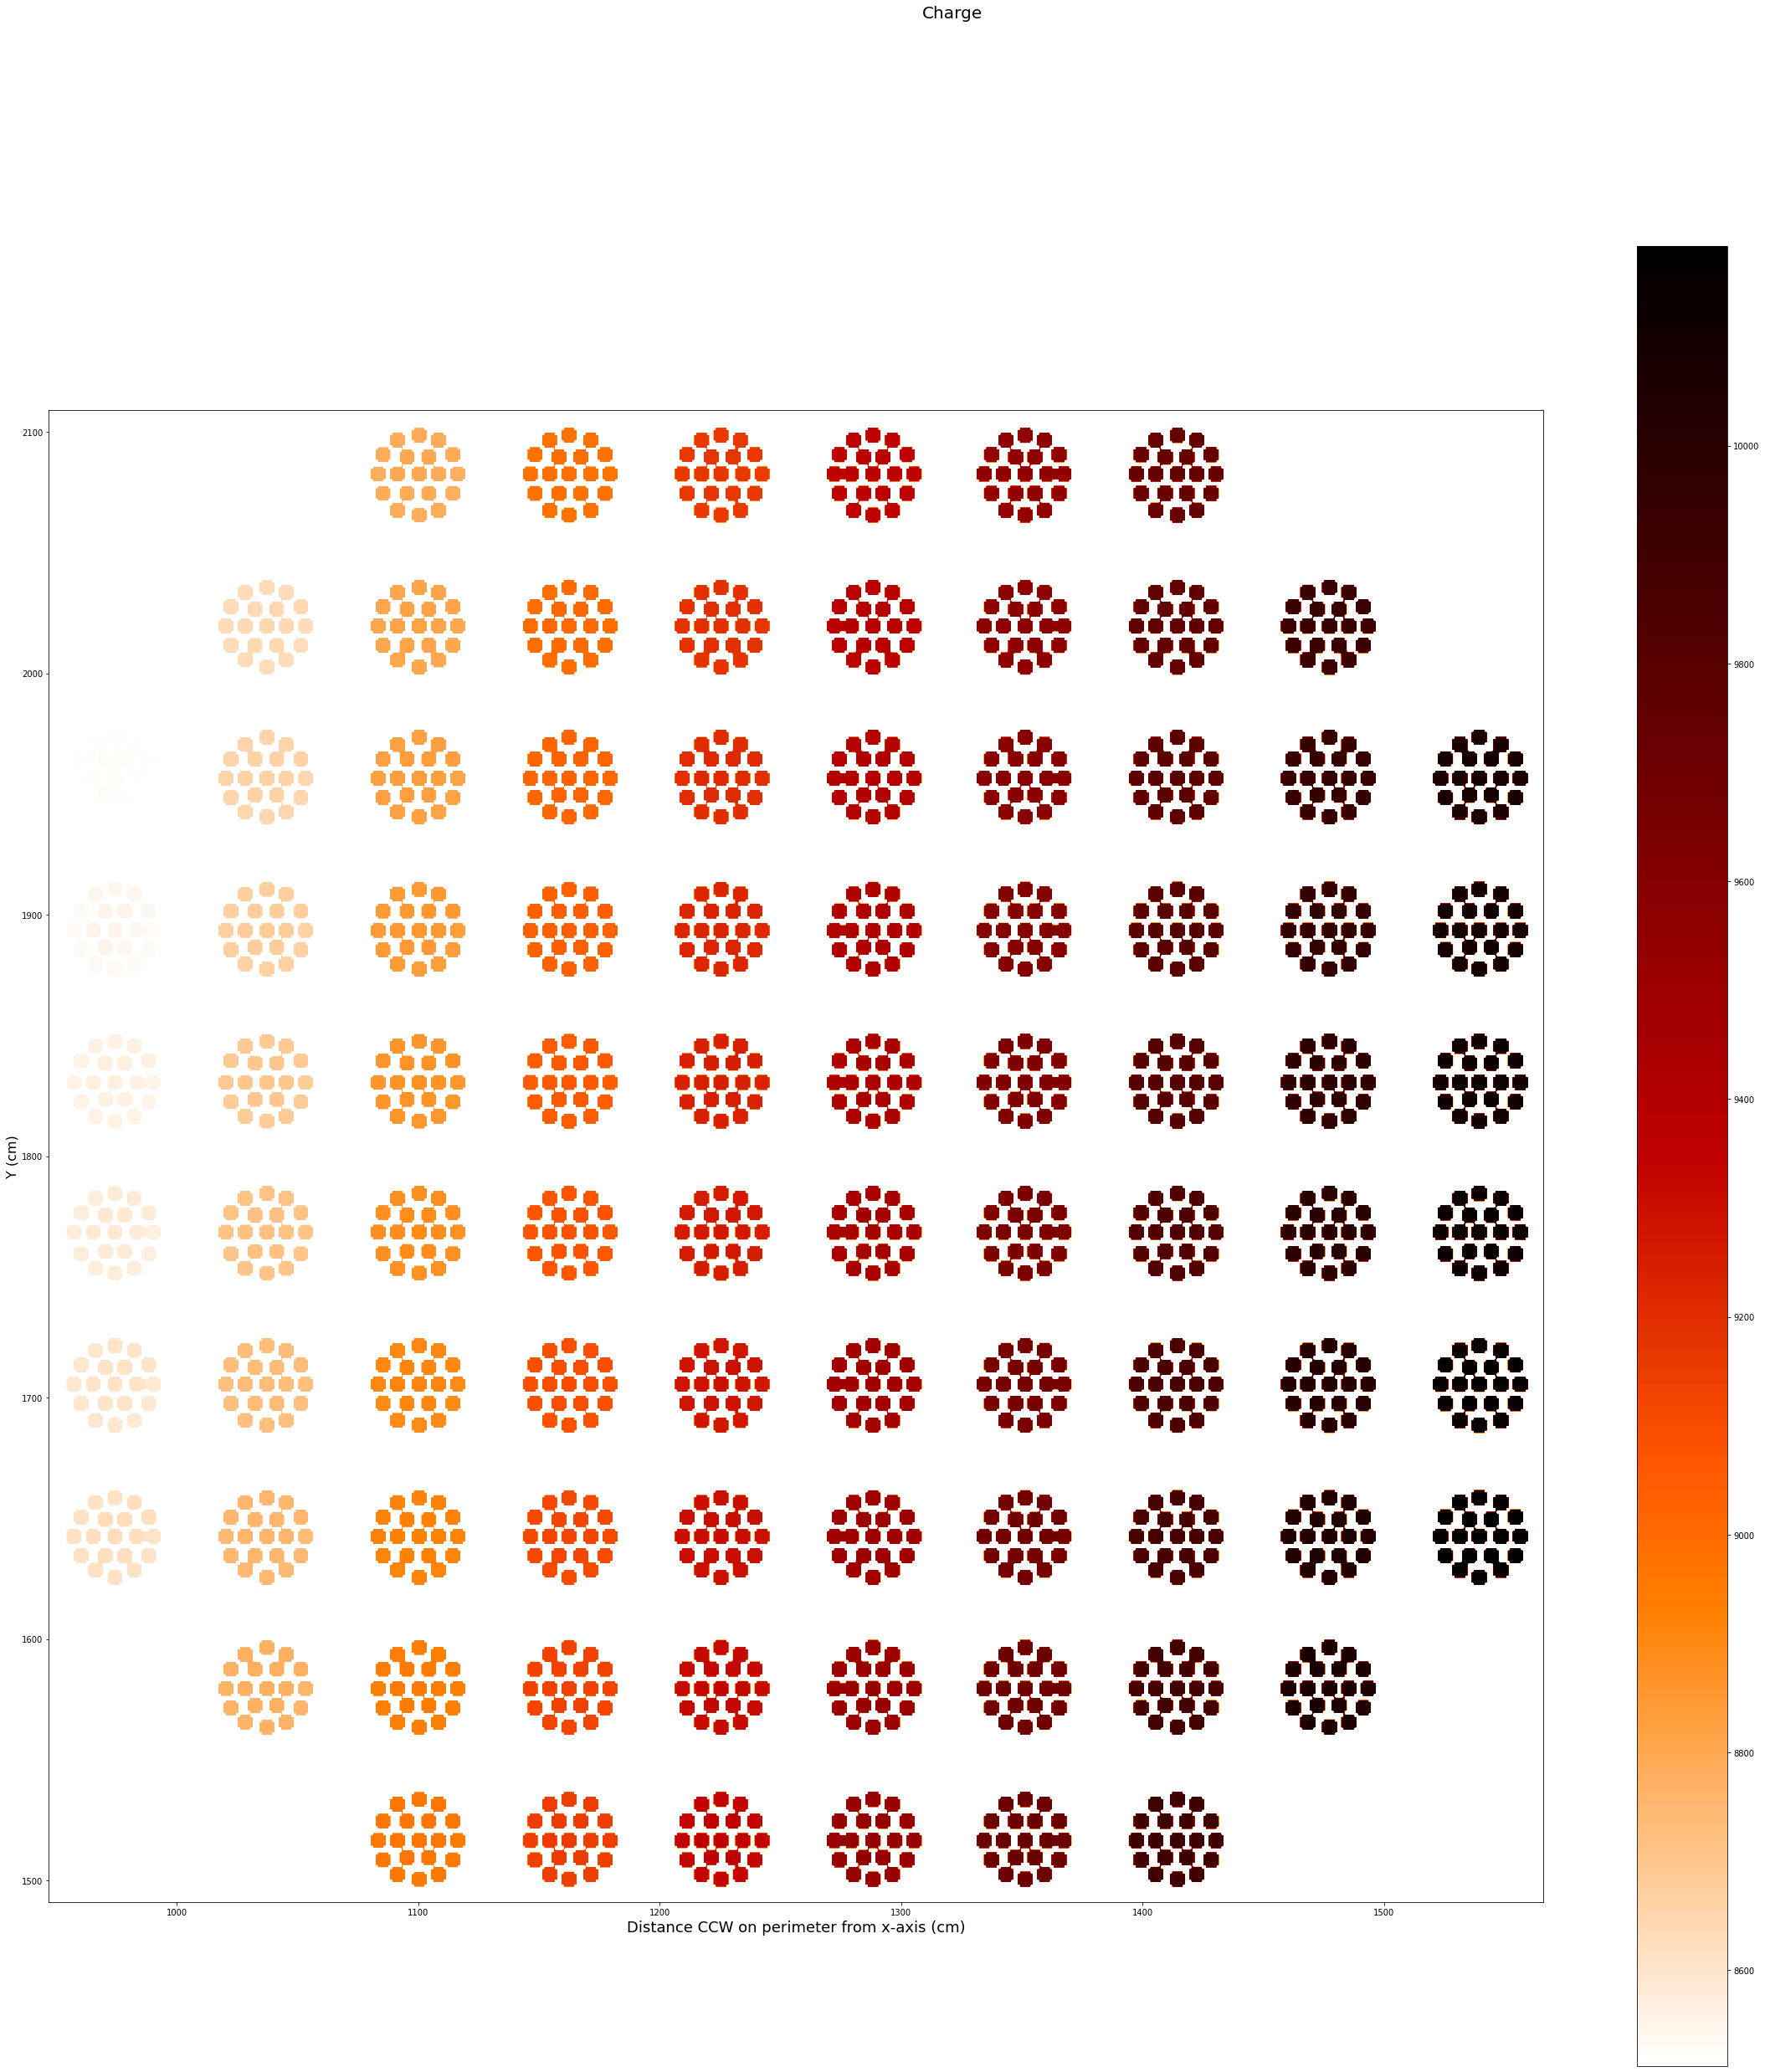

In [232]:
EventSubsetDisplay(tubes - 1, tubes - 1, np.array(upper_endcap_subset_tubes) - 1)

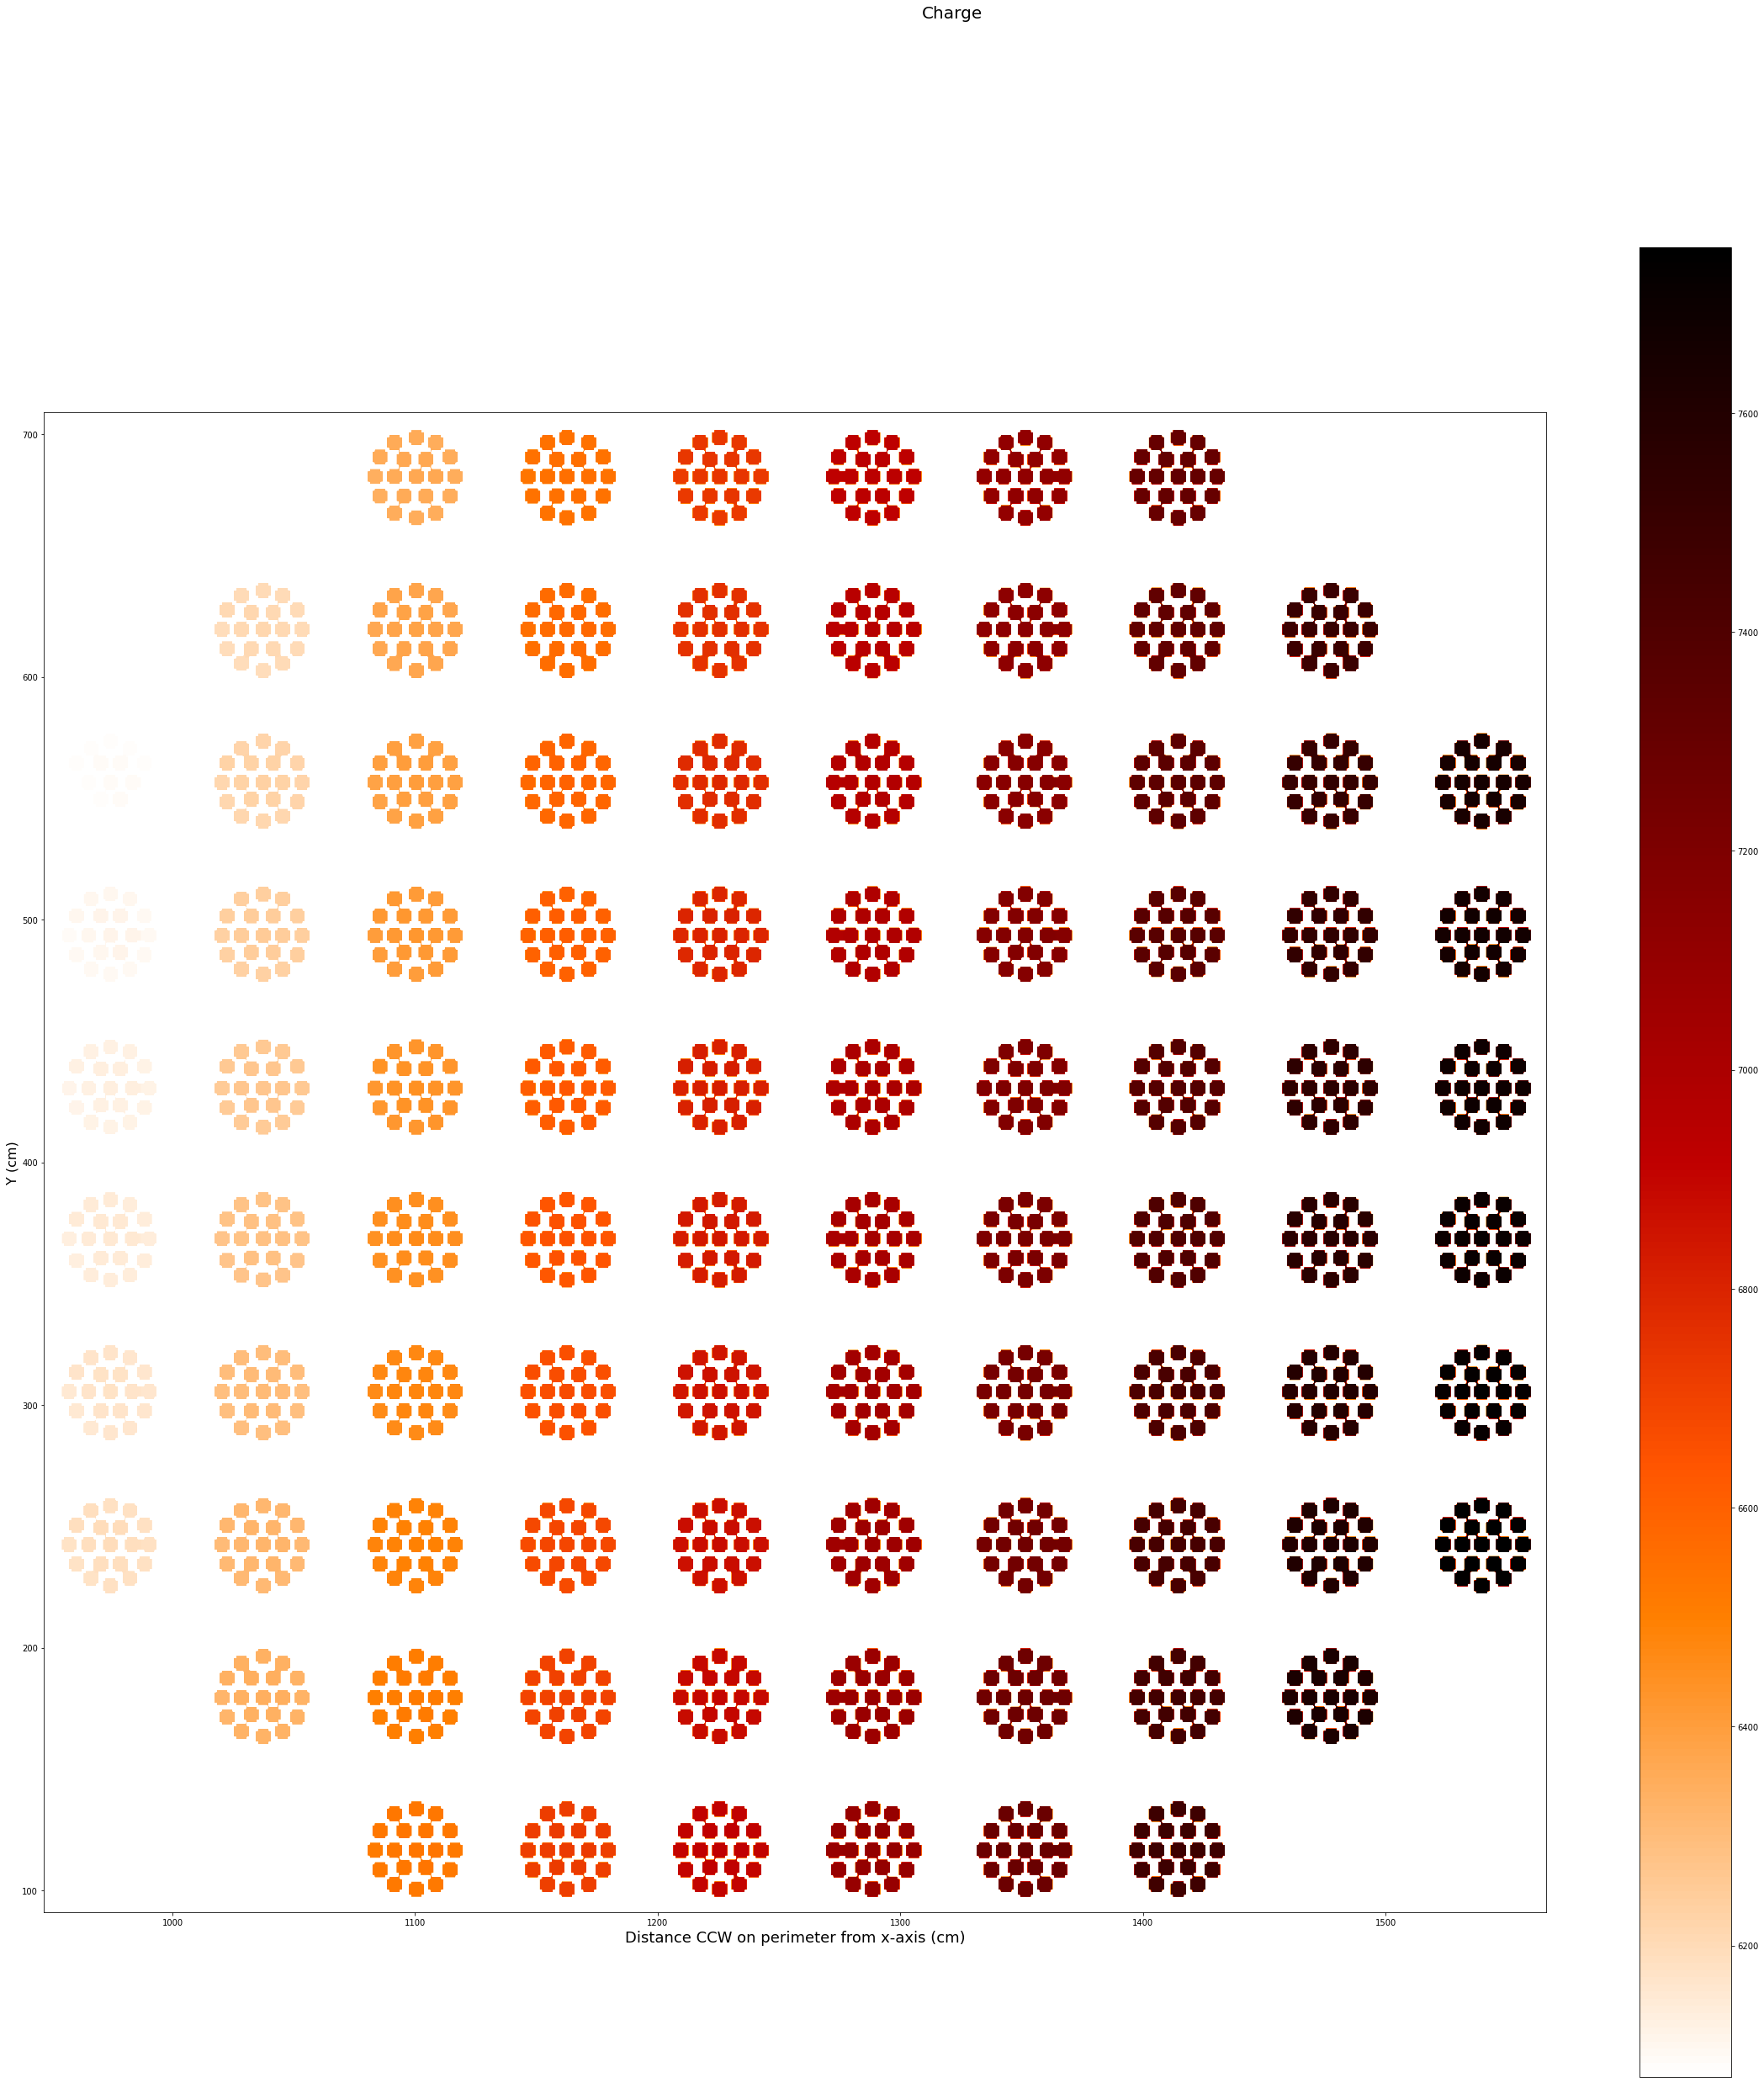

In [233]:
EventSubsetDisplay(tubes - 1, tubes - 1, np.array(lower_endcap_subset_tubes) - 1)

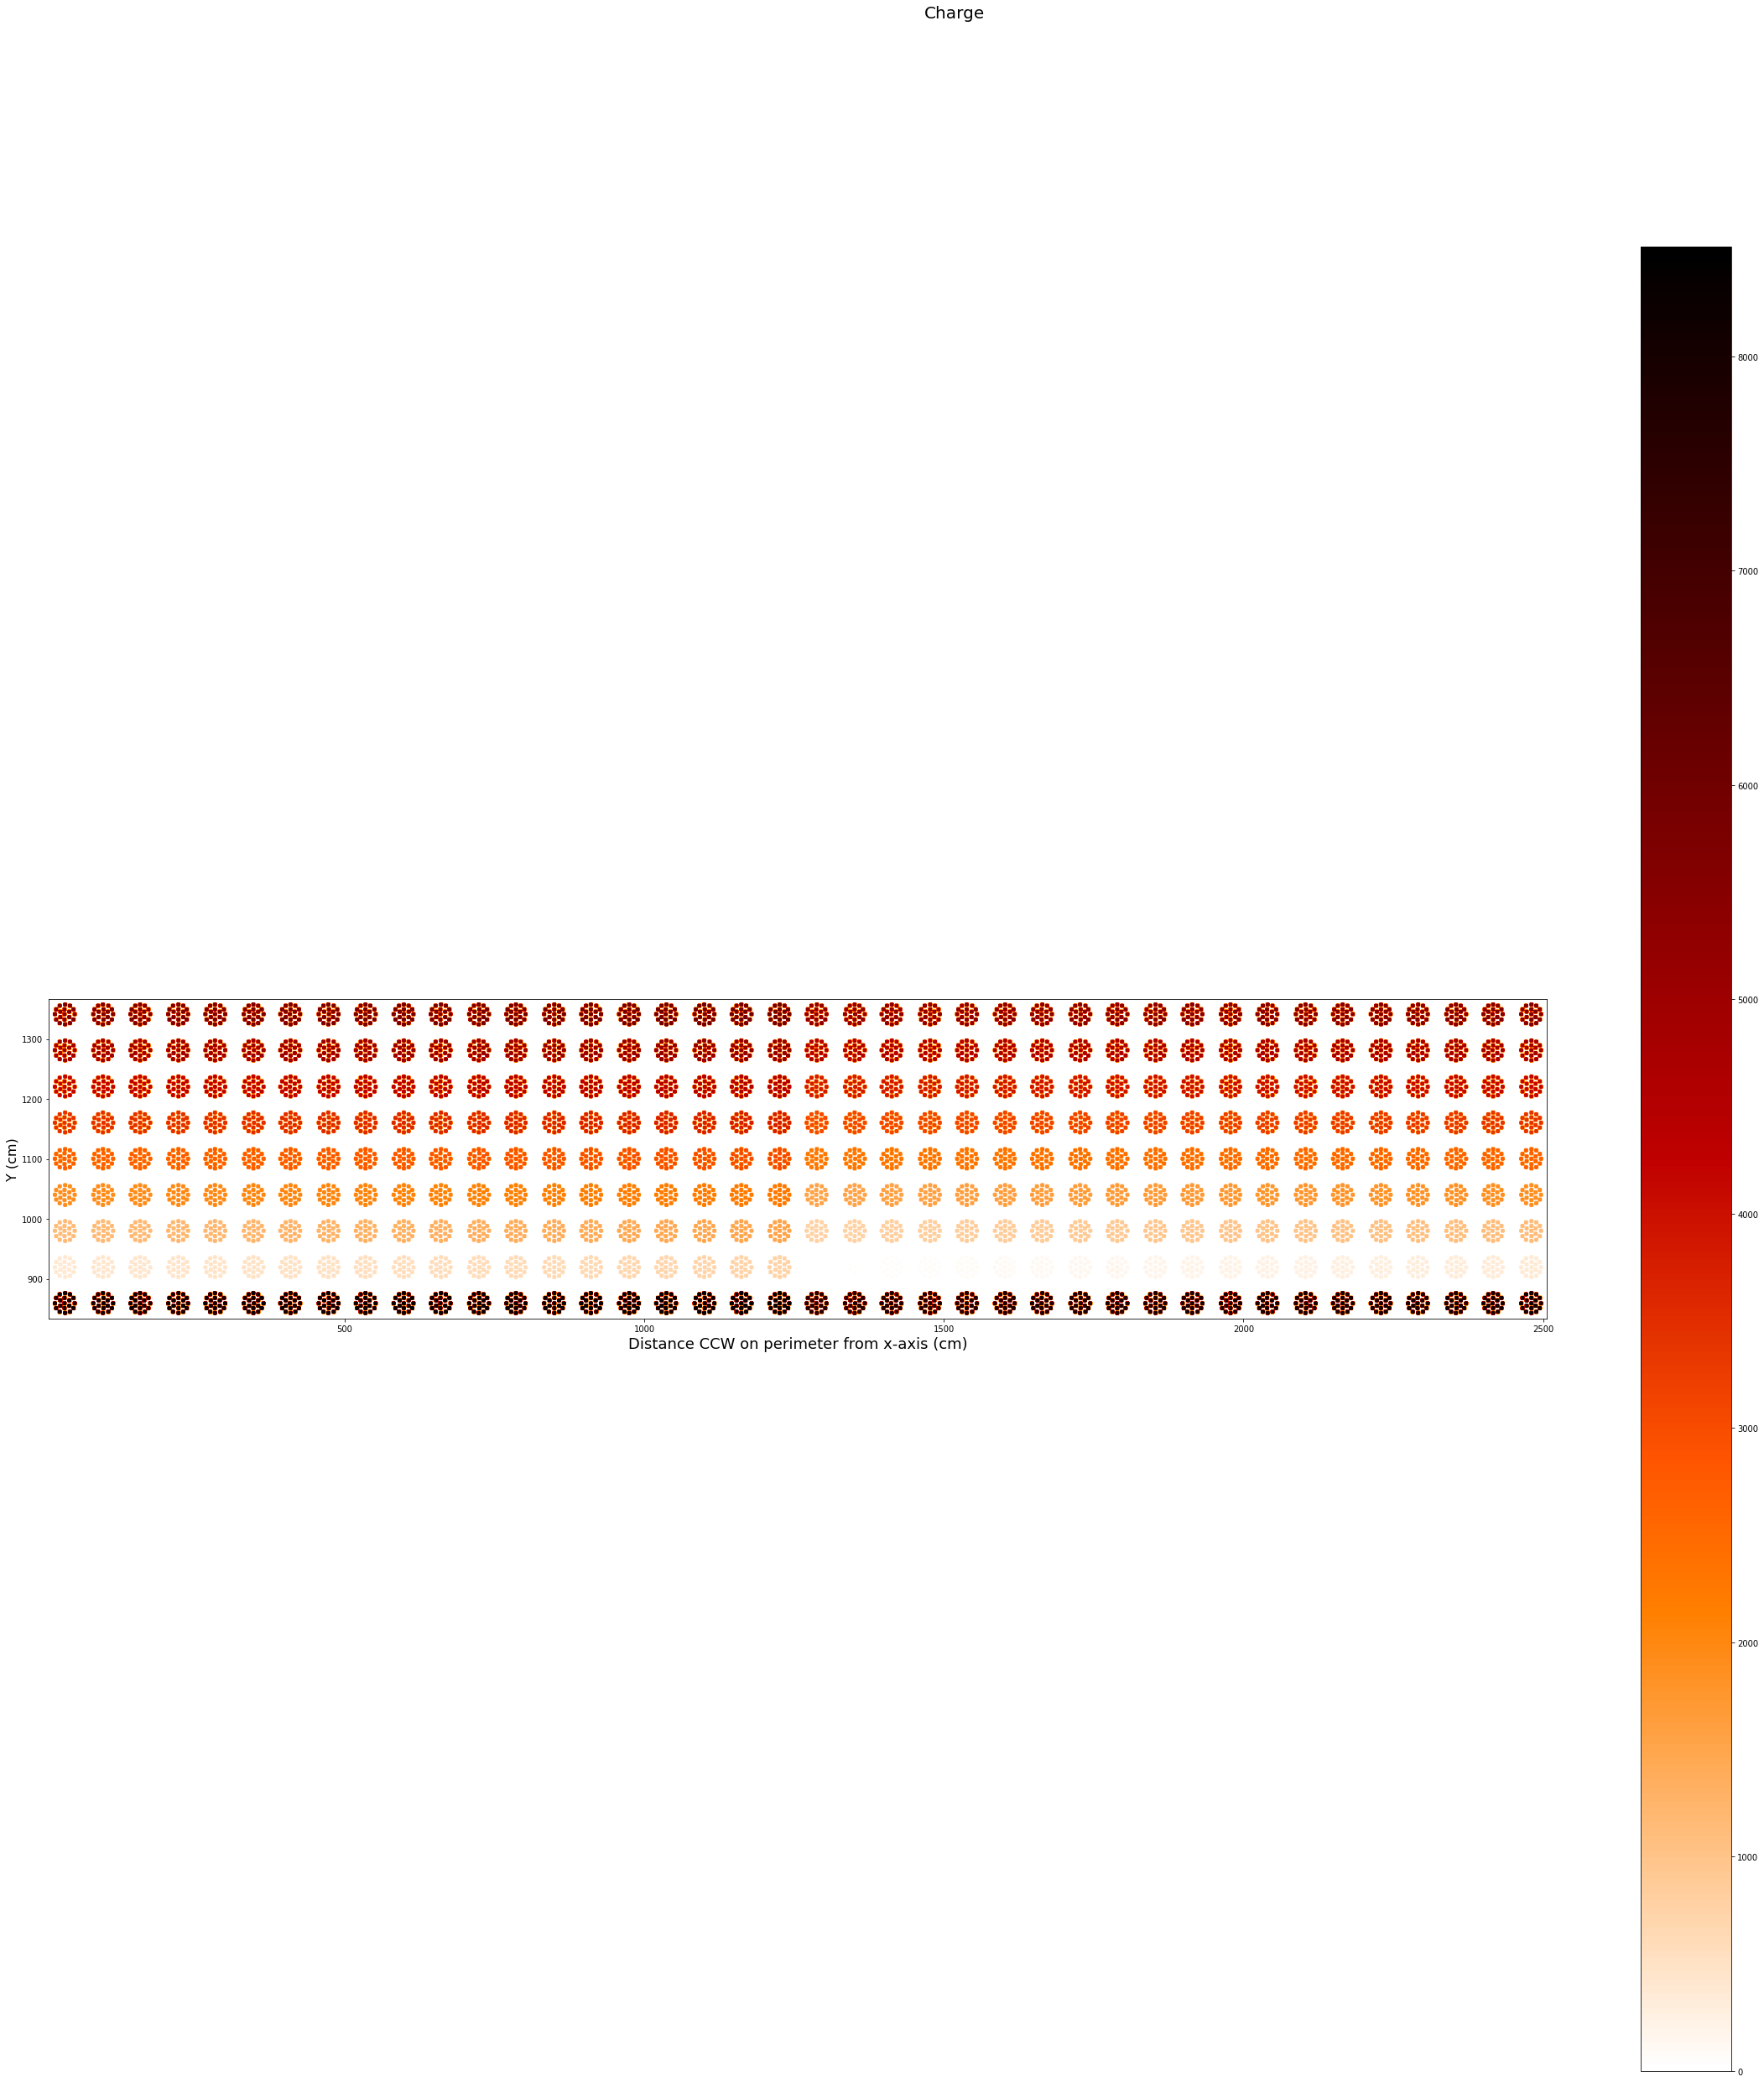

In [230]:
EventSubsetDisplay(tubes - 1, tubes - 1, np.array(barrel_subset_tubes) - 1)

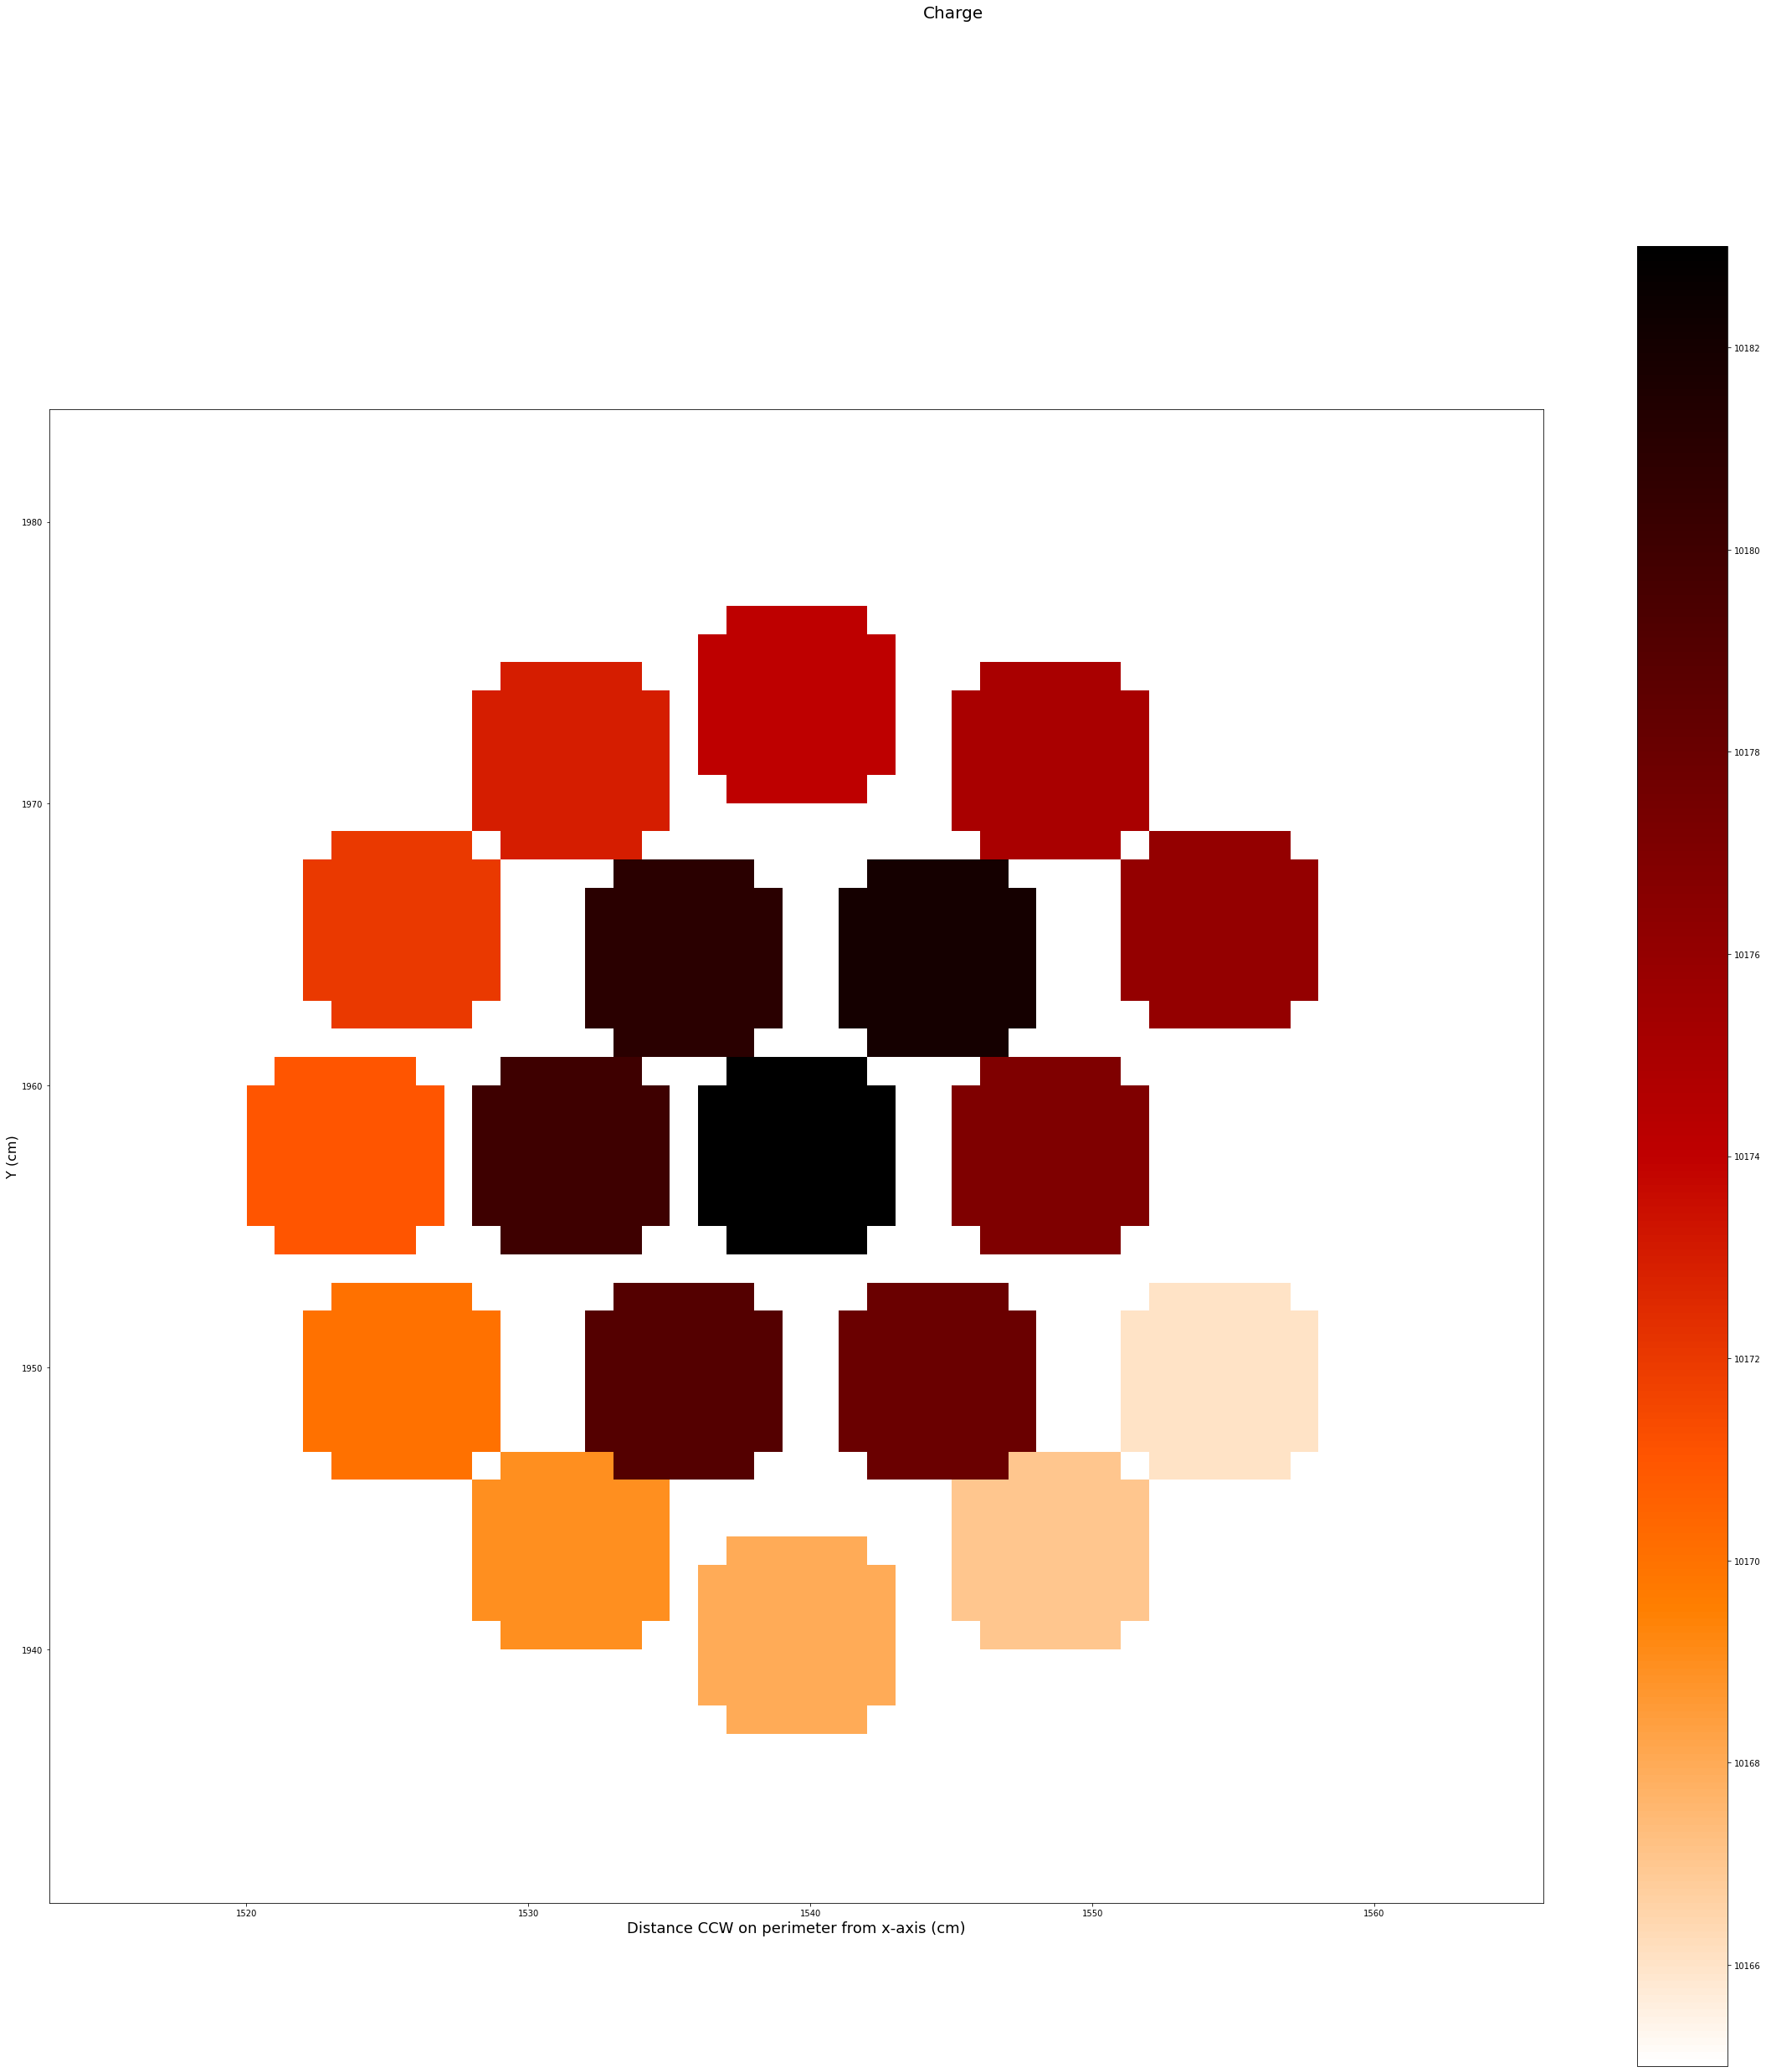

In [235]:
EventSubsetDisplay(tubes - 1, tubes - 1, np.array(upper_endcap_subset_tubes[-19:]) - 1)

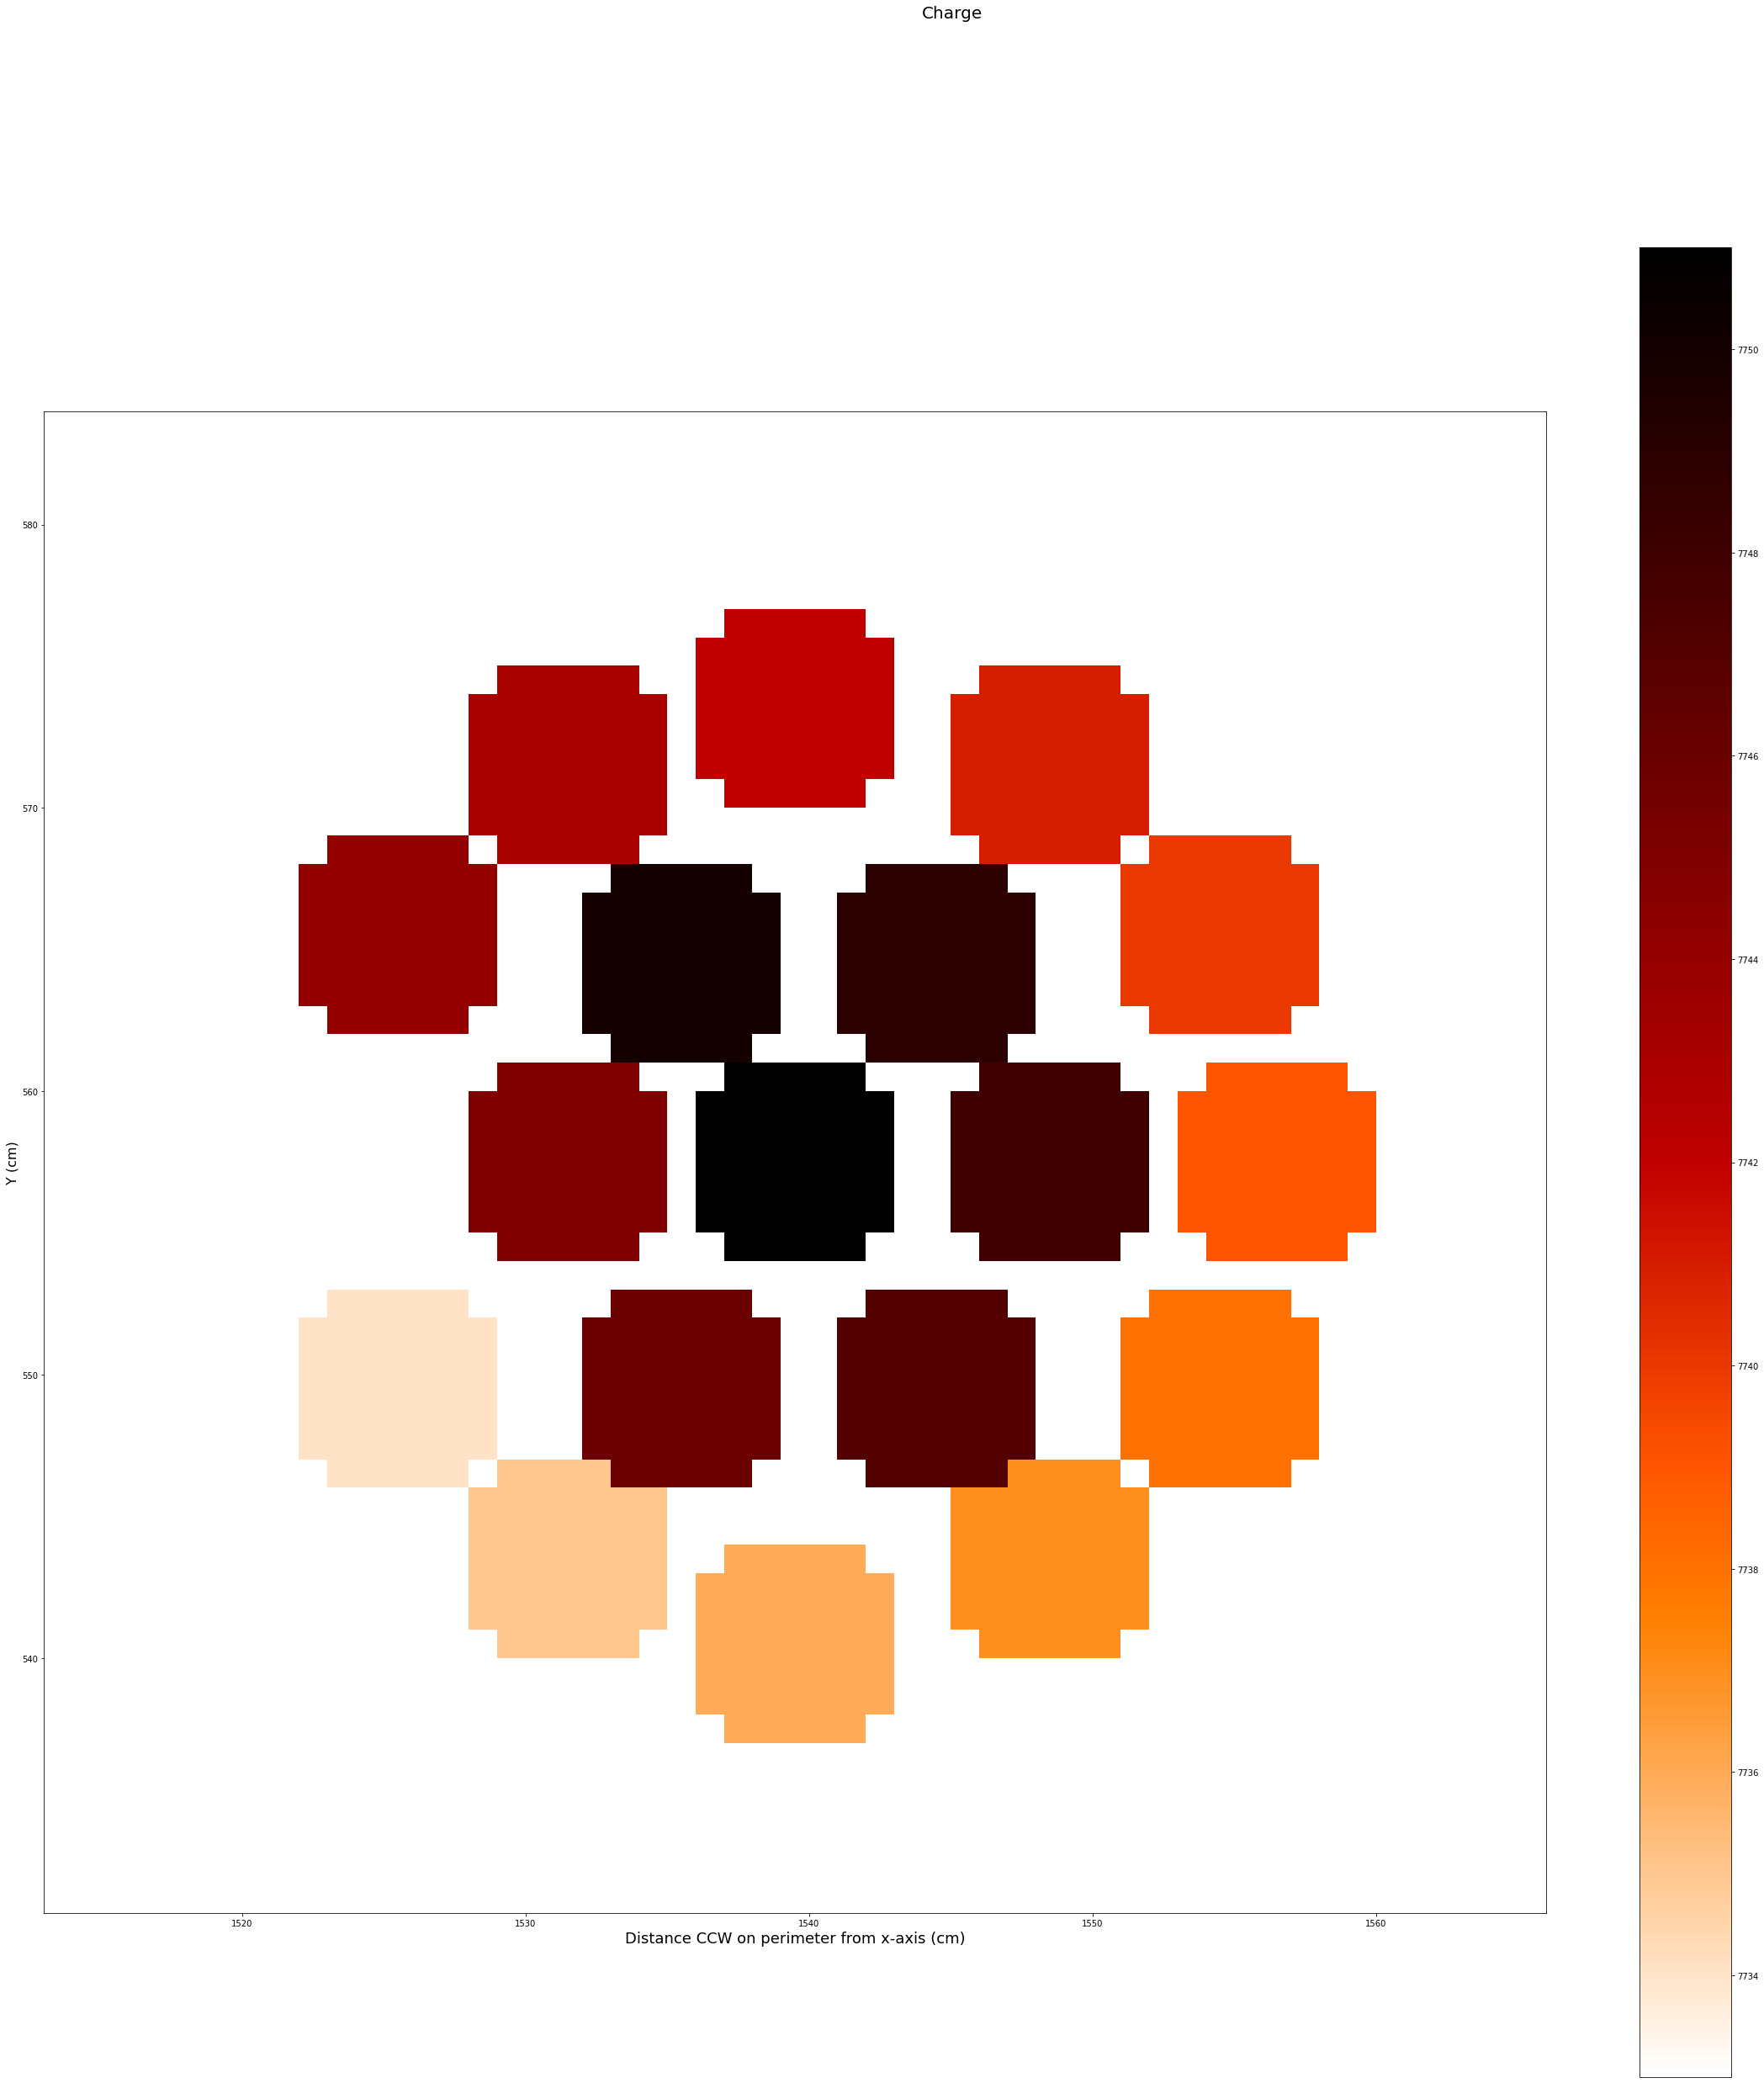

In [238]:
EventSubsetDisplay(tubes - 1, tubes - 1, np.array(lower_endcap_subset_tubes[-19:]) - 1)

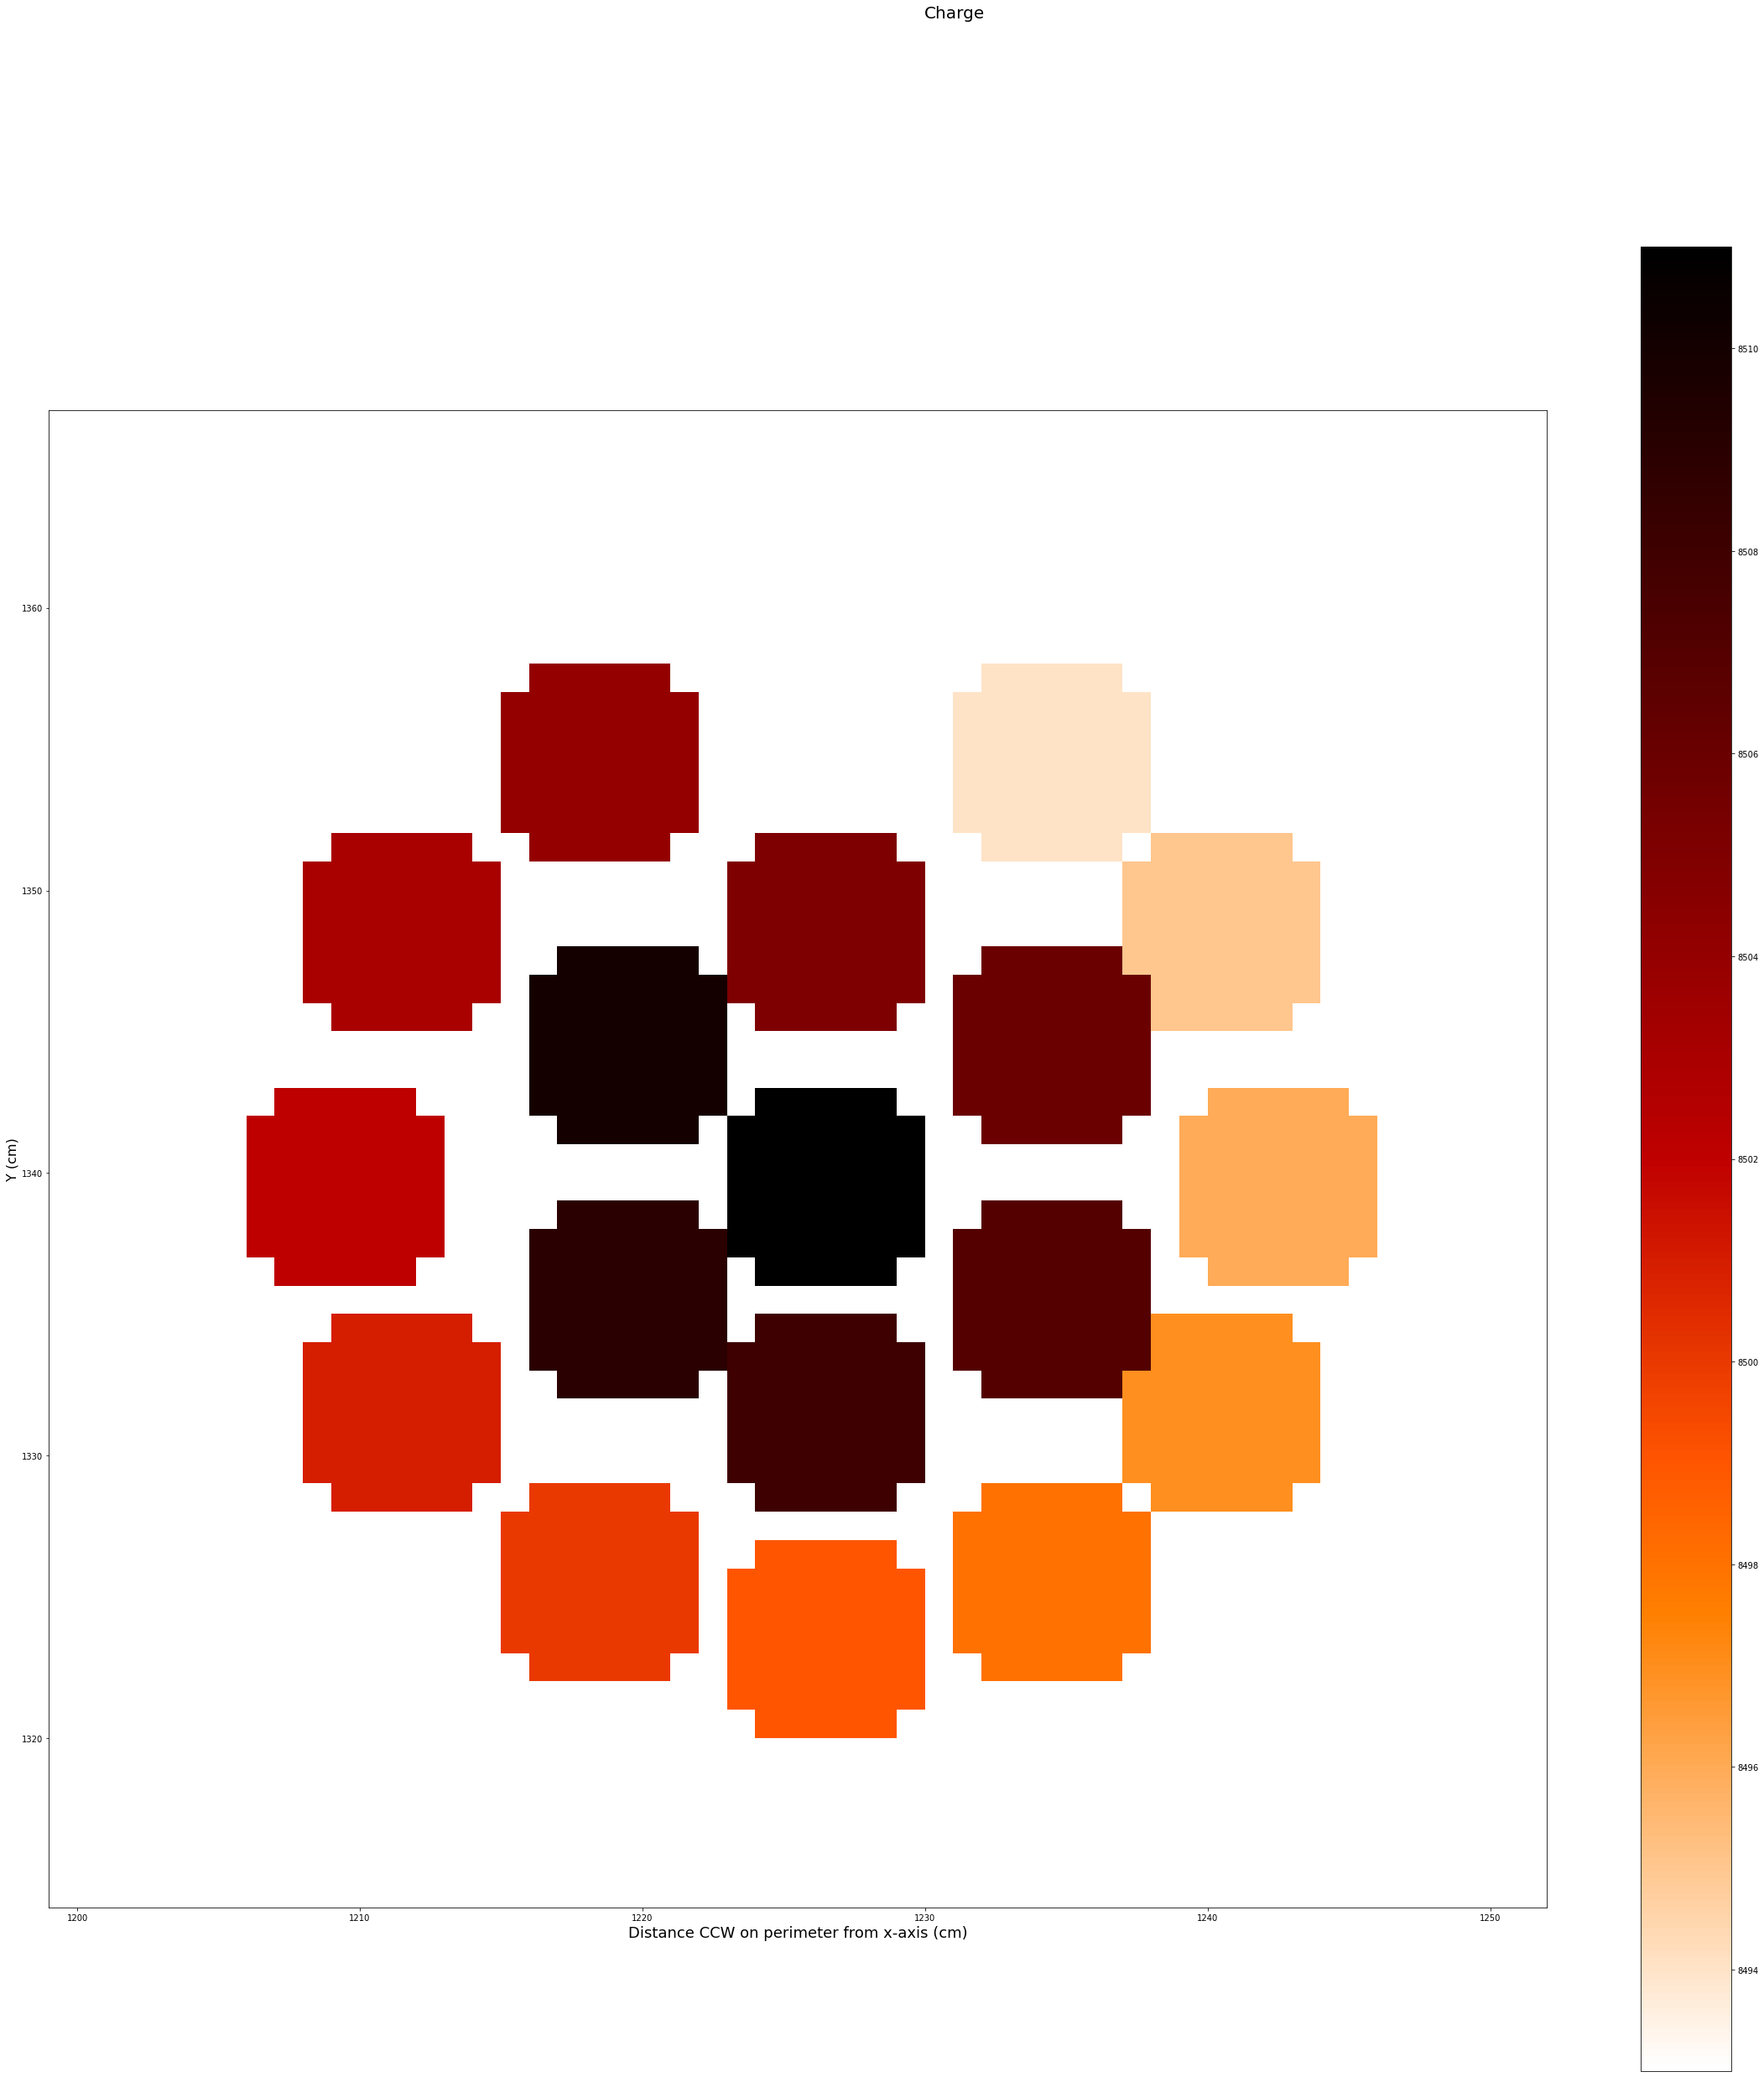

In [236]:
EventSubsetDisplay(tubes - 1, tubes - 1, np.array(barrel_subset_tubes[-19:]) - 1)

In [239]:
barrel_tubes = np.array(barrel_subset_tubes[-19:])
print(barrel_tubes)

[8494 8495 8496 8497 8498 8499 8500 8501 8502 8503 8504 8505 8506 8507
 8508 8509 8510 8511 8512]


In [276]:
item=0
start = event_hits_index[item]
stop  = event_hits_index[item + 1]

#hit_pmts    = hit_pmt[start:stop].astype(np.int16)
#hit_charges = hit_charge[start:stop]
#hit_times   = hit_time[start:stop]

hit_pmts    = tubes - 1
hit_charges = tubes

hit_mpmts = hit_pmts // pmts_per_mpmt
hit_pmt_in_modules = hit_pmts % pmts_per_mpmt

hit_rows = mpmt_positions[hit_mpmts, 0]
hit_cols = mpmt_positions[hit_mpmts, 1]

print(hit_pmt_in_modules)

sample_data = np.zeros(data_size)
print(sample_data.shape)
print(19*29*40)
print(len(hit_charge))
sample_data[hit_pmt_in_modules, hit_rows, hit_cols] = hit_charges

print(hit_charges)
#print(set(list(sample_data.flatten())))

# fix barrel array indexing to match endcaps in xyz ordering
barrel_map_array_idxs = [6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 15, 16, 17, 12, 13, 14, 18]

sample_data[:, 12:28, :] = sample_data[barrel_map_array_idxs, 12:28, :]

[ 0  1  2 ... 16 17 18]
(10184,)
22040
10184
[    1     2     3 ... 10182 10183 10184]


In [280]:
def test_get_event_data_from_index():
    #hit_pmts    = hit_pmt[start:stop].astype(np.int16)
    #hit_charges = hit_charge[start:stop]
    #hit_times   = hit_time[start:stop]

    hit_pmts    = tubes - 1
    hit_charges = tubes

    hit_mpmts = hit_pmts // pmts_per_mpmt
    hit_pmt_in_modules = hit_pmts % pmts_per_mpmt

    hit_rows = mpmt_positions[hit_mpmts, 0]
    hit_cols = mpmt_positions[hit_mpmts, 1]

    sample_data = np.zeros(data_size)
    sample_data[hit_pmt_in_modules, hit_rows, hit_cols] = hit_charges

    # fix barrel array indexing to match endcaps in xyz ordering
    barrel_map_array_idxs = [6, 7, 8, 9, 10, 11, 0, 1, 2, 3, 4, 5, 15, 16, 17, 12, 13, 14, 18]
    sample_data[:, 12:28, :] = sample_data[barrel_map_array_idxs, 12:28, :]
    
    return hit_pmts, sample_data[hit_pmt_in_modules, hit_rows, hit_cols].flatten() 

In [281]:
shuffle_fix_pmts, shuffle_fix_tube_ids = test_get_event_data_from_index()

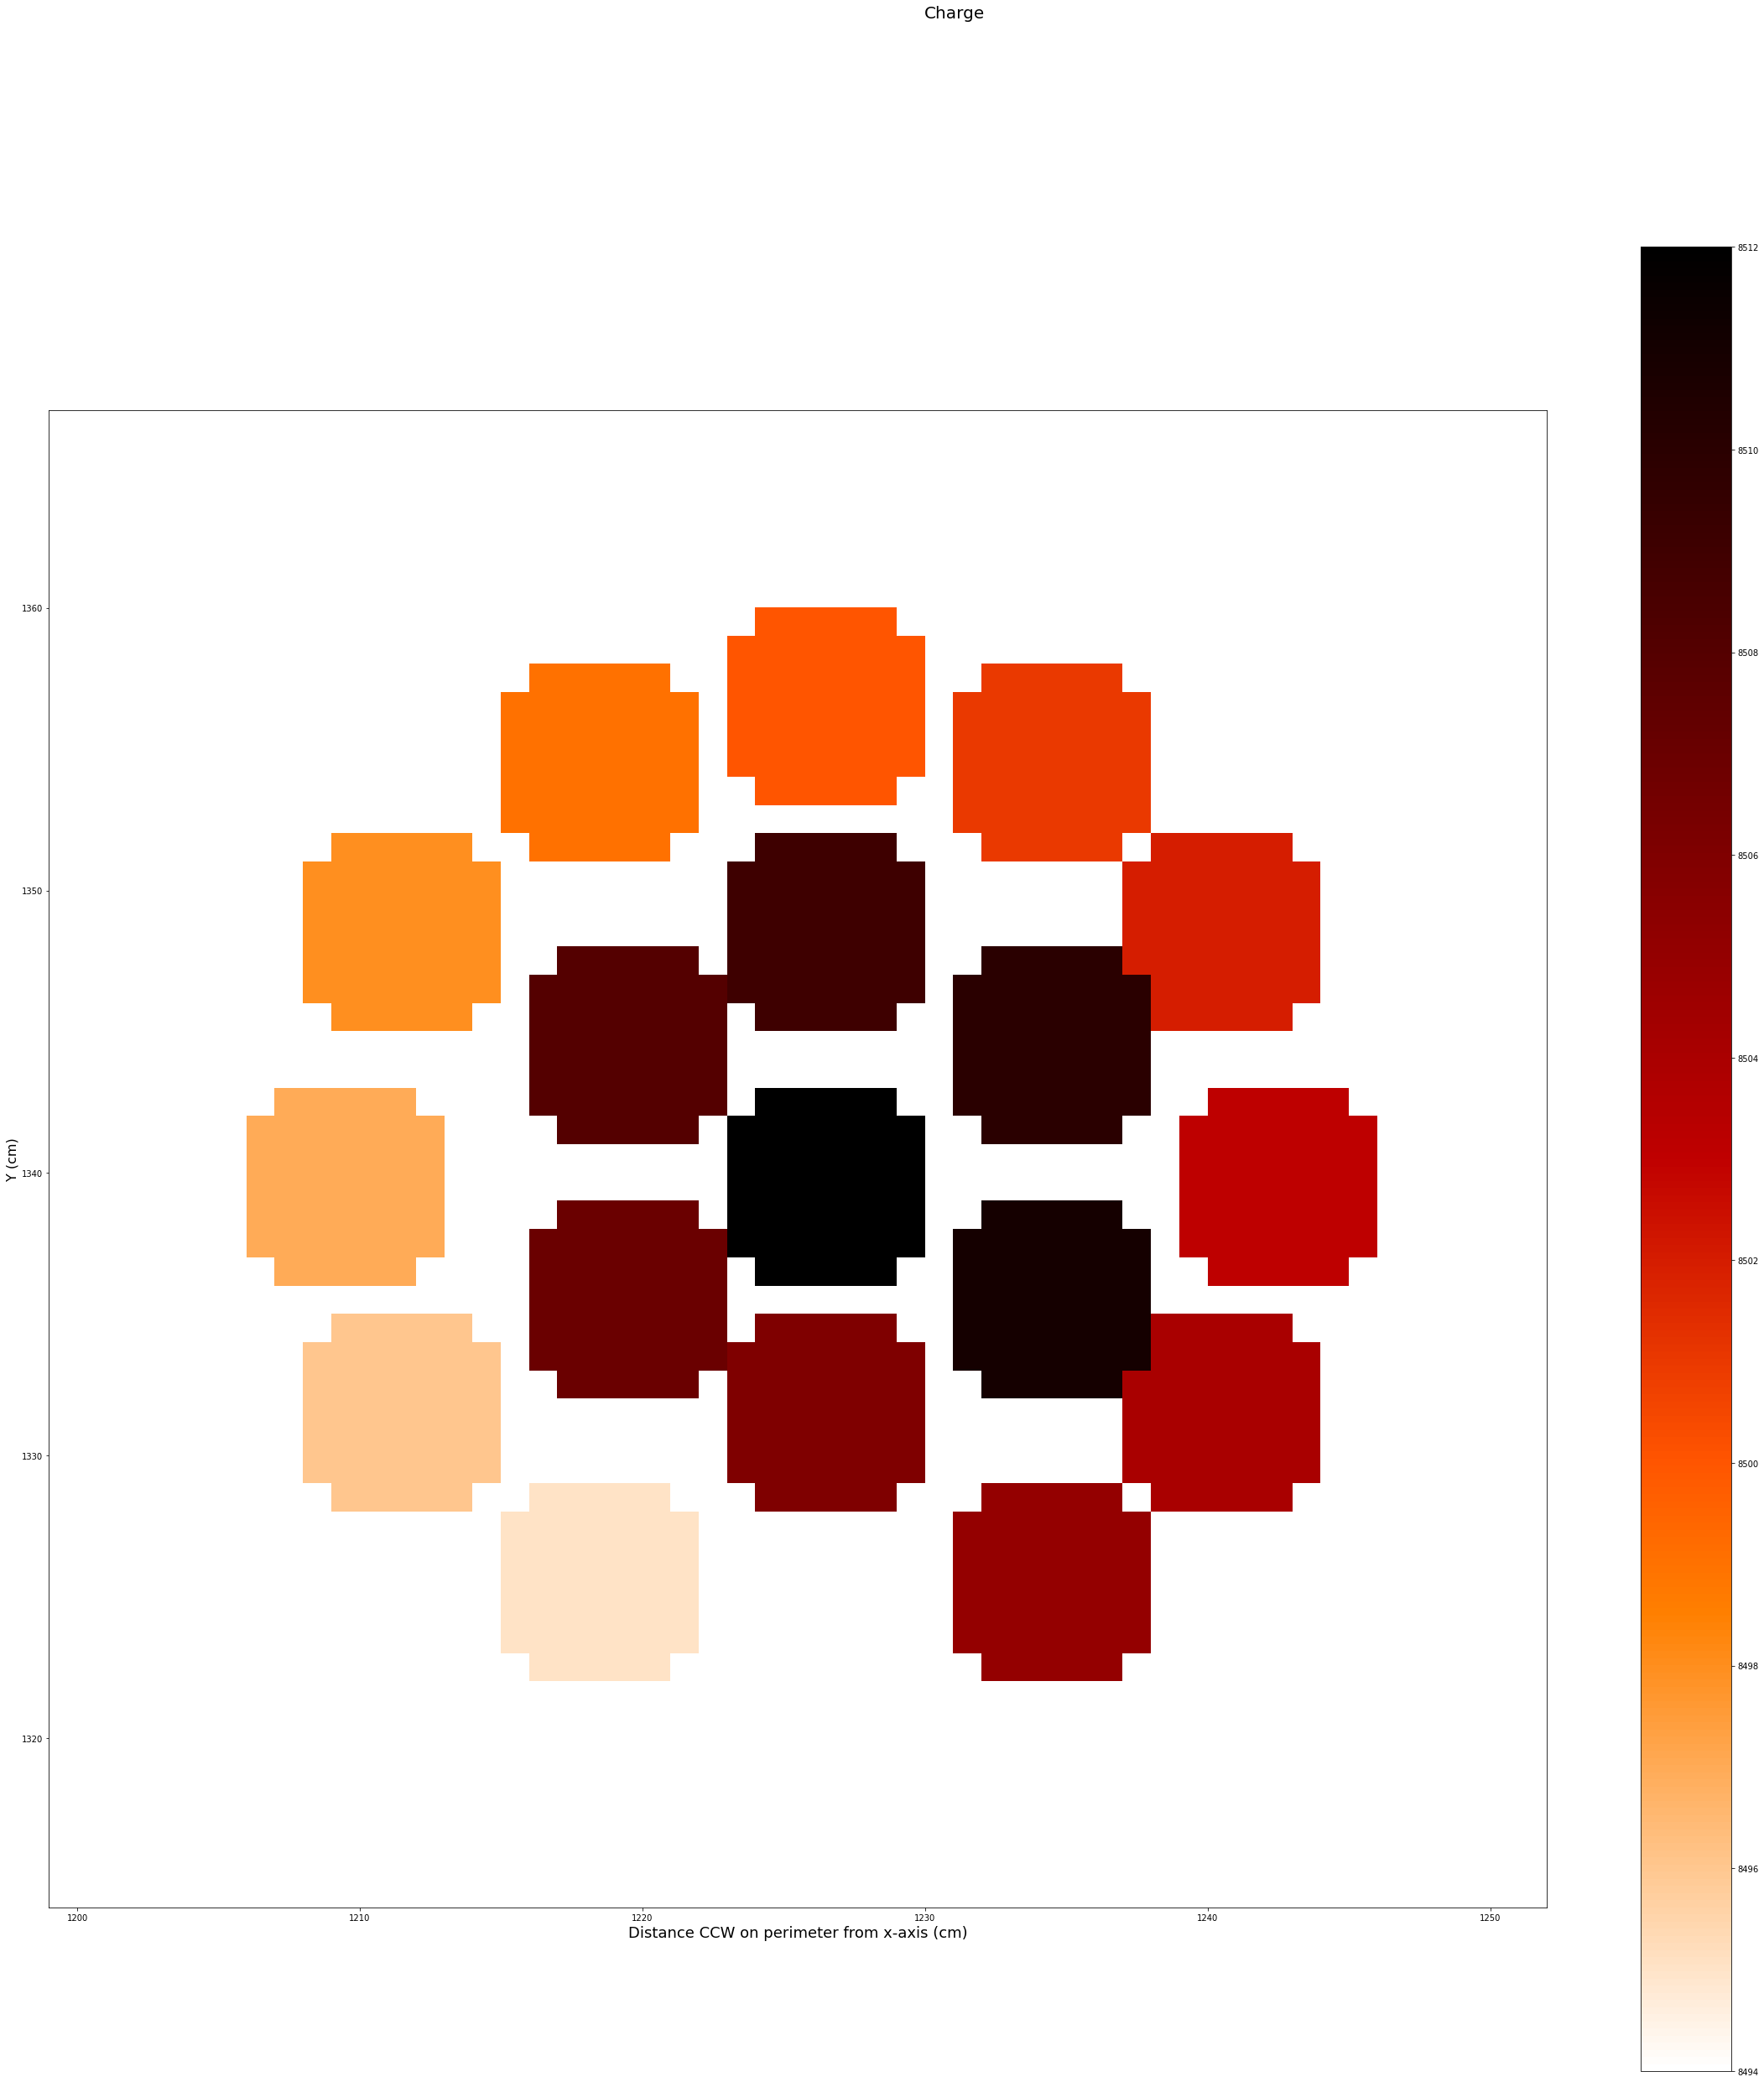

In [282]:
EventSubsetDisplay(shuffle_fix_pmts, shuffle_fix_tube_ids, np.array(barrel_subset_tubes[-19:]) - 1)